[DATA] X_raw shape = (17881, 13) (#features = 13 )


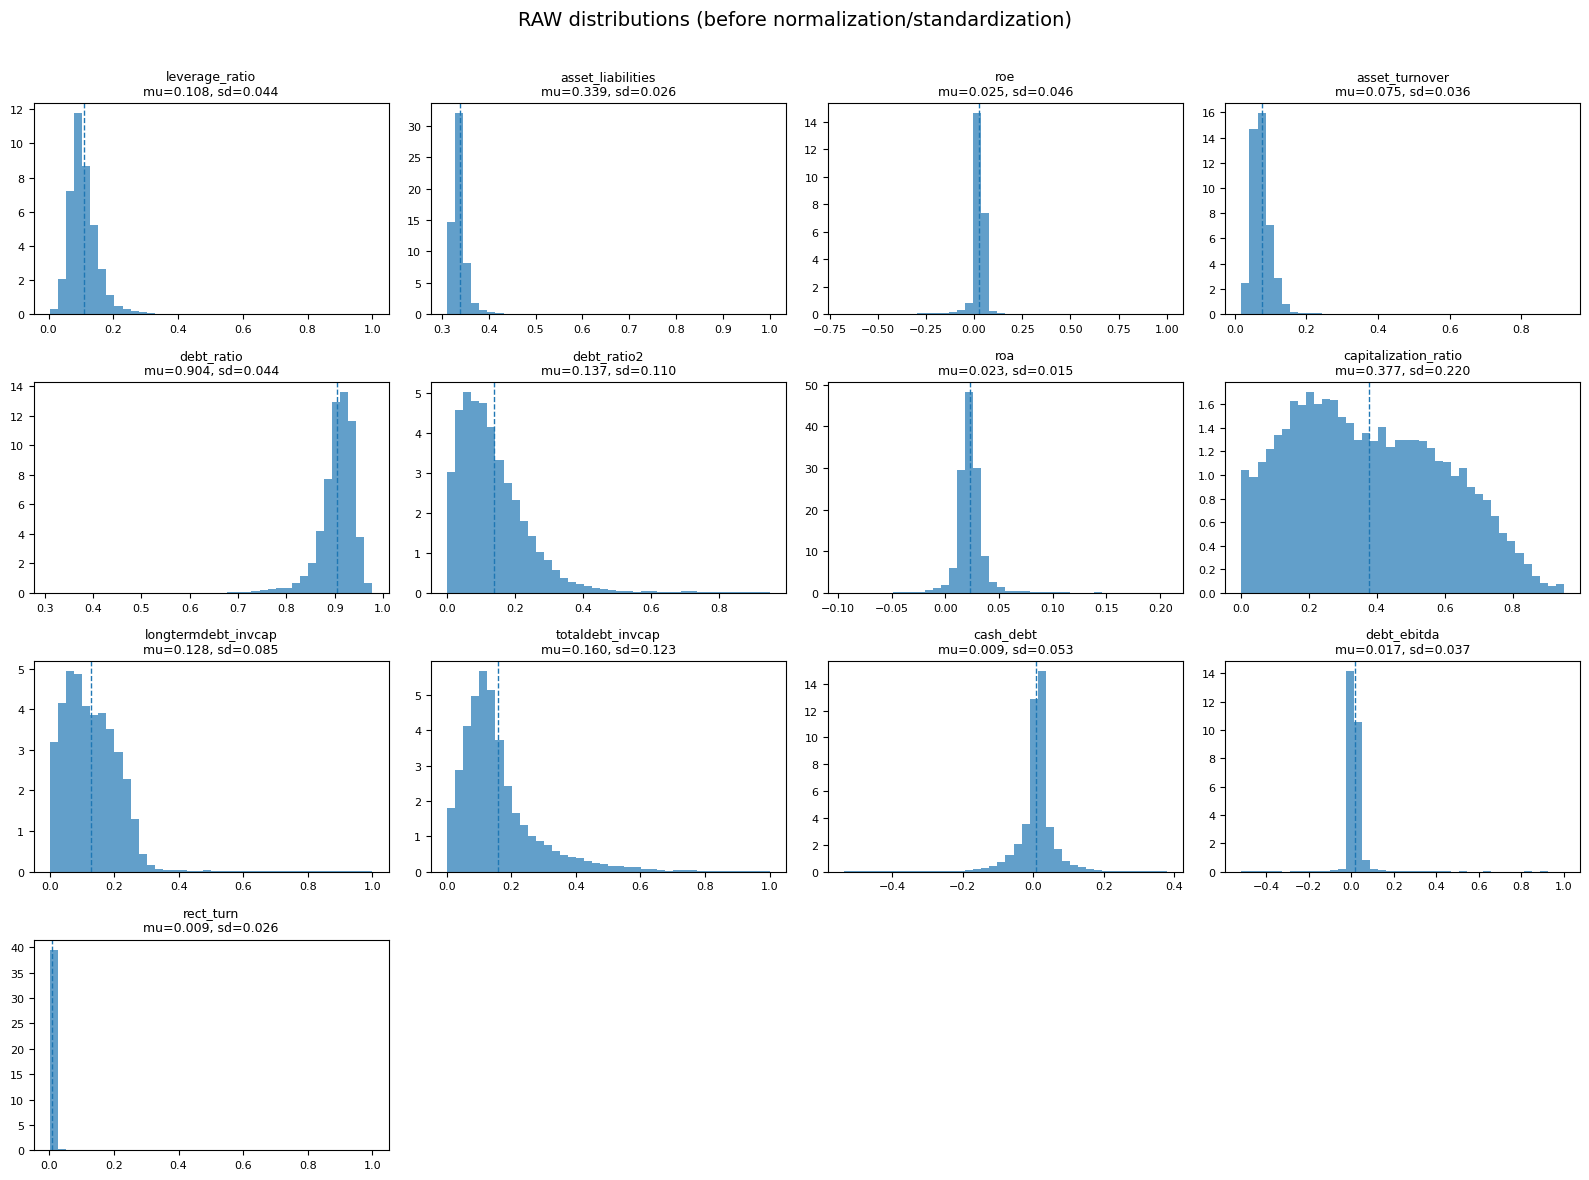

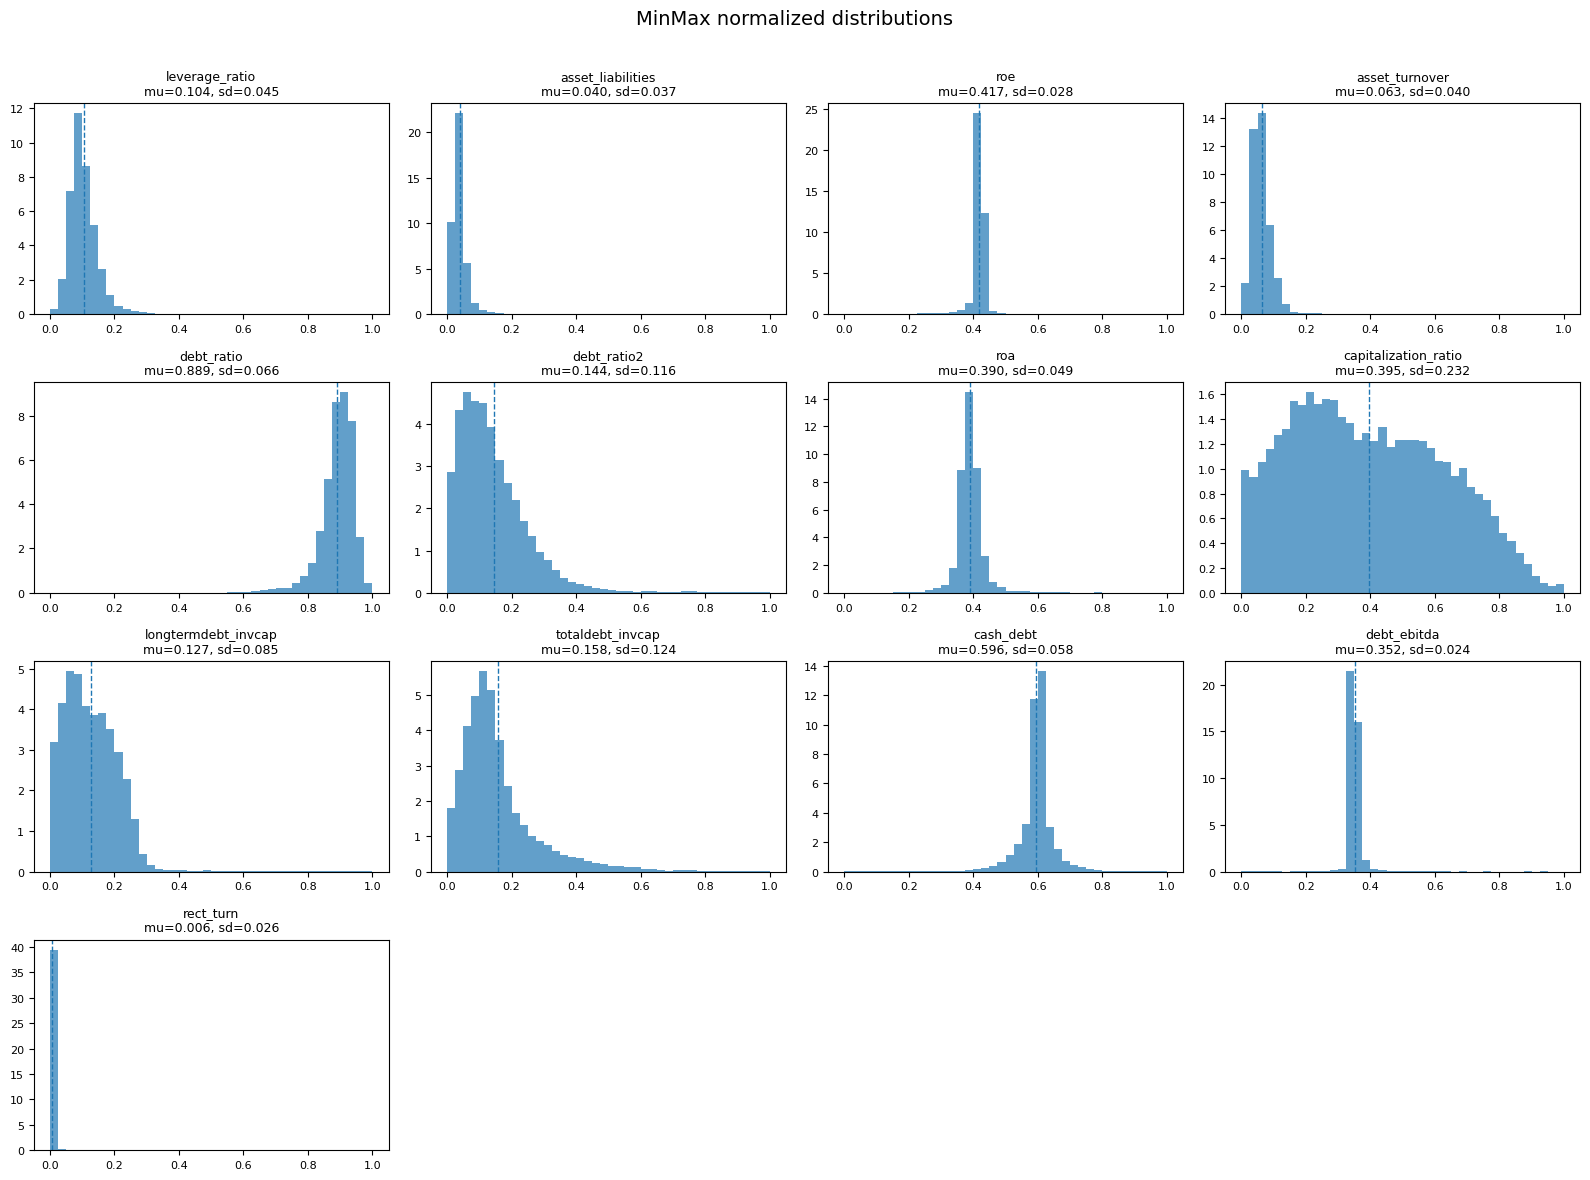

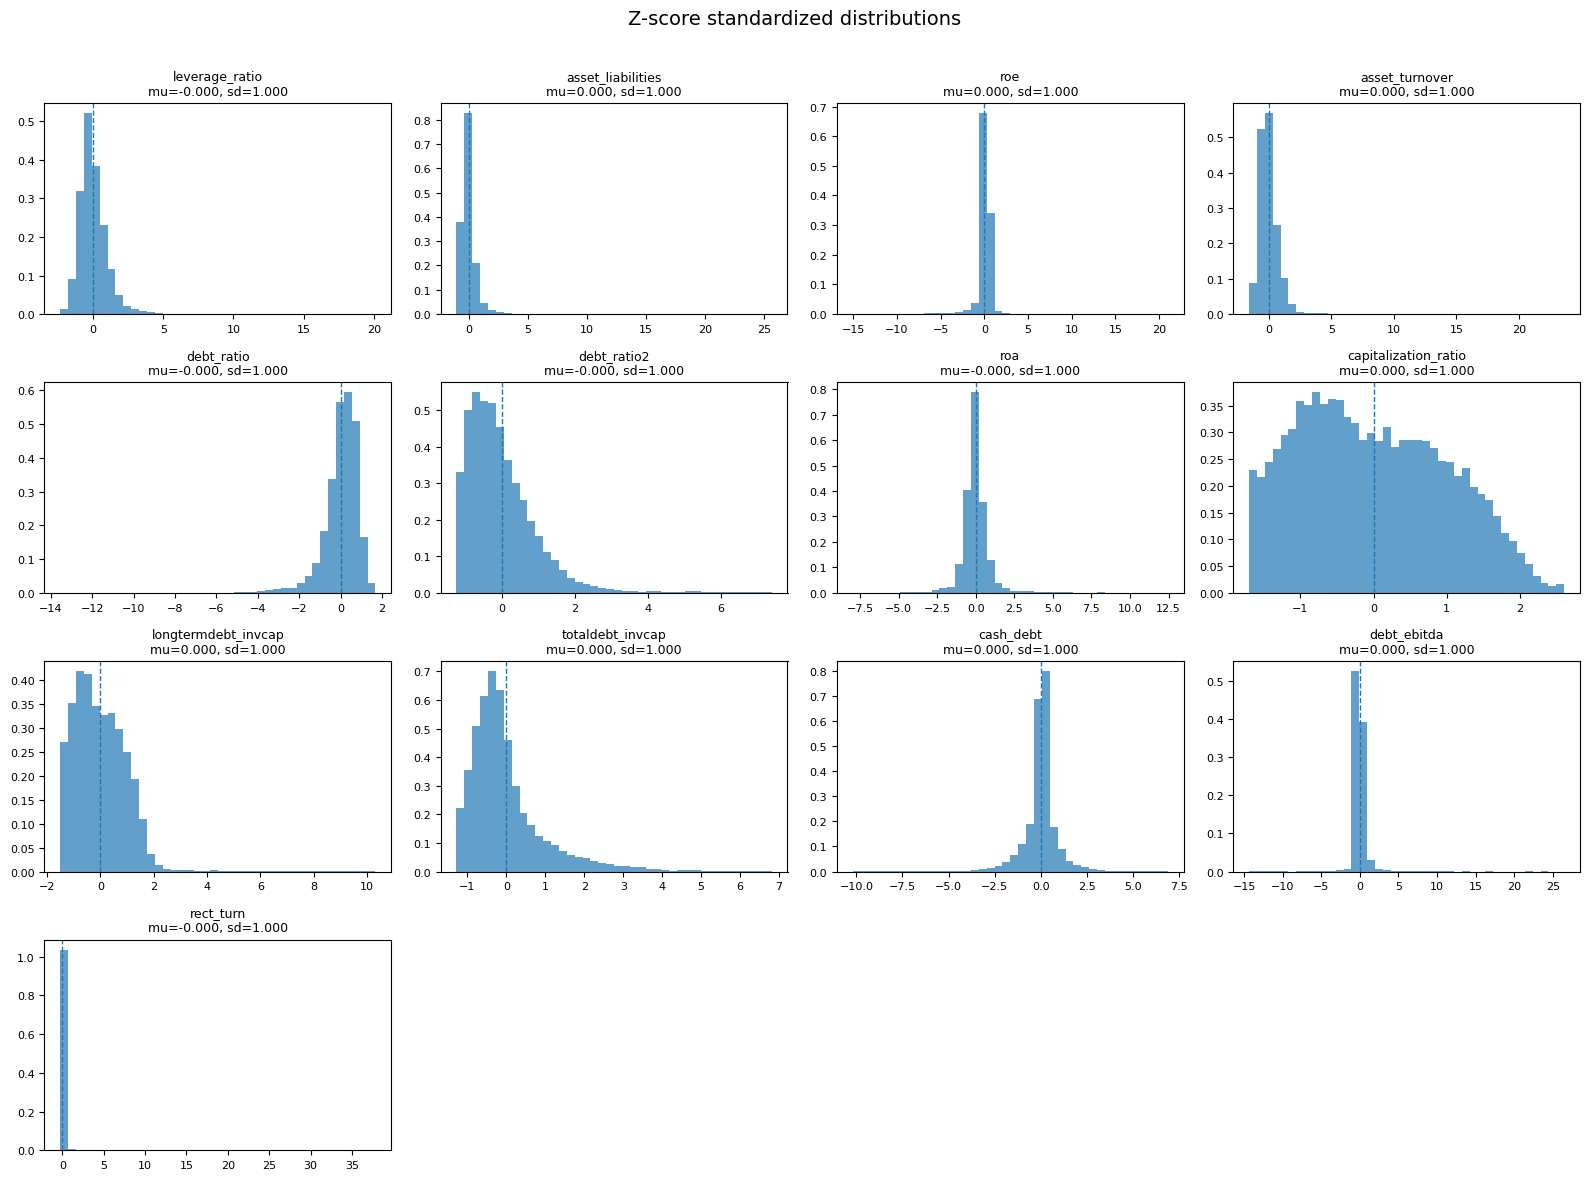

[GES INPUT] = standard
[GES] structure learned. (A[child,parent]=1)
[OLS] W estimated on standardized data (Z-score).
[EDGE SUMMARY]
- threshold(|w|) = 0.010000
- TOP_K_EDGES = None
- Selected edges = 35 (pos: 22, neg: 13)
- Nonzero W entries before threshold: 35
  debt_ratio -> asset_liabilities: w=-1.0511
  capitalization_ratio -> debt_ratio2: w=+0.9820
  leverage_ratio -> debt_ratio: w=+0.7070
  totaldebt_invcap -> debt_ratio2: w=+0.5995
  rect_turn -> asset_turnover: w=+0.4397
  asset_turnover -> roa: w=+0.4085
  roe -> roa: w=+0.4084
  longtermdebt_invcap -> debt_ratio2: w=-0.3610
  debt_ratio2 -> debt_ebitda: w=+0.3483
  rect_turn -> debt_ratio: w=-0.3325
  debt_ratio -> debt_ratio2: w=-0.3270
  asset_liabilities -> cash_debt: w=+0.2618
  leverage_ratio -> asset_liabilities: w=+0.2477
  debt_ratio -> cash_debt: w=+0.1871
  rect_turn -> roa: w=+0.1845
  roa -> debt_ebitda: w=-0.1731
  roa -> debt_ratio2: w=+0.1700
  leverage_ratio -> roa: w=-0.1670
  asset_liabilities -> debt_rati

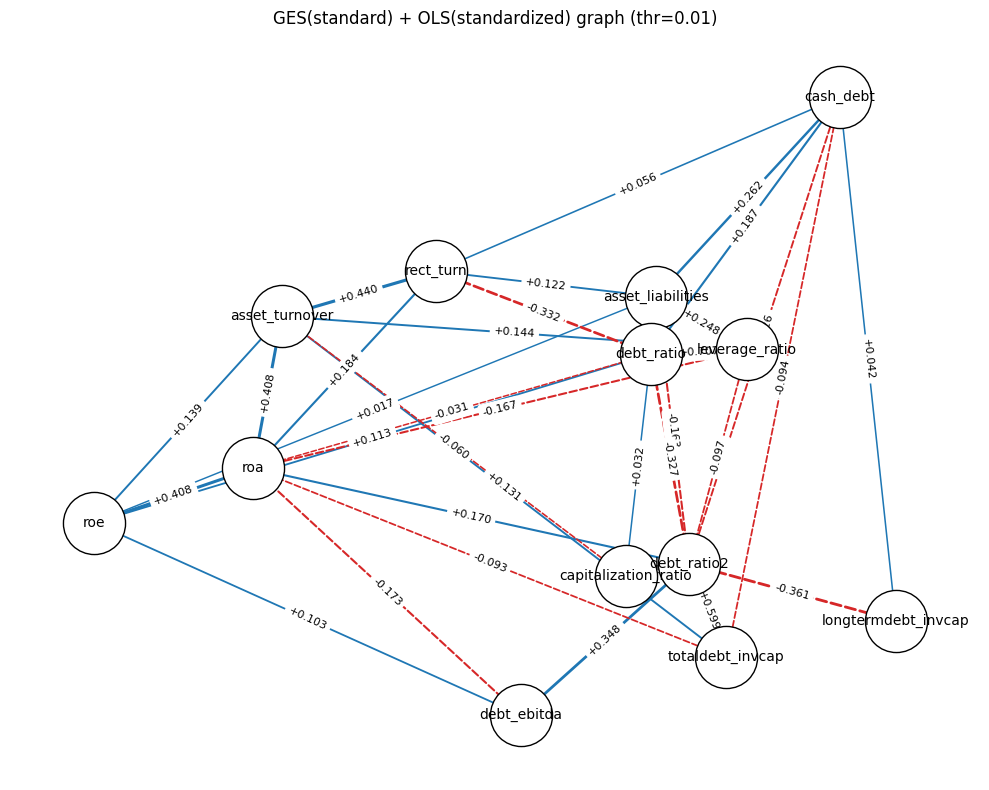


[asset_turnover 으로 들어가는 edge 목록]
rect_turn - +0.4397 - asset_turnover
leverage_ratio - +0.1442 - asset_turnover
roe - +0.1394 - asset_turnover
totaldebt_invcap - +0.1313 - asset_turnover
capitalization_ratio - -0.0599 - asset_turnover
-> target edges saved: ges_standard_ols_standard_edges_to_asset_turnover.csv


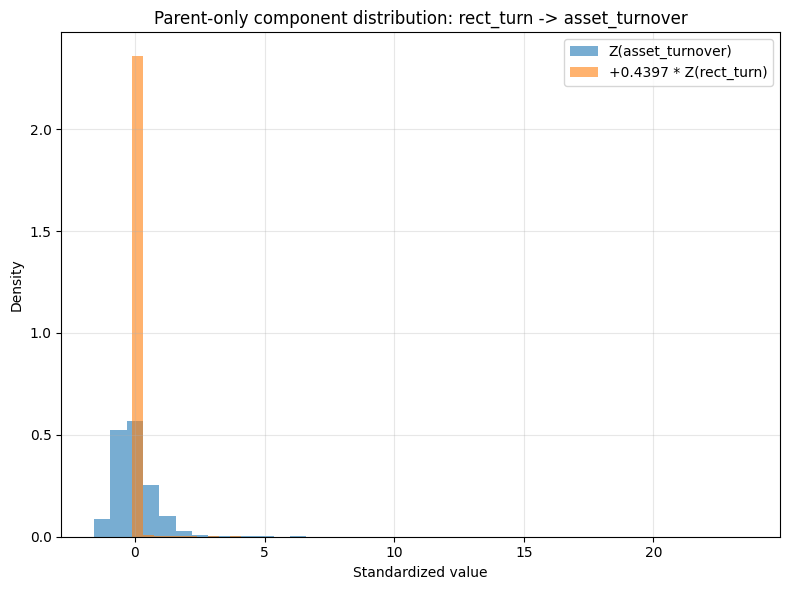

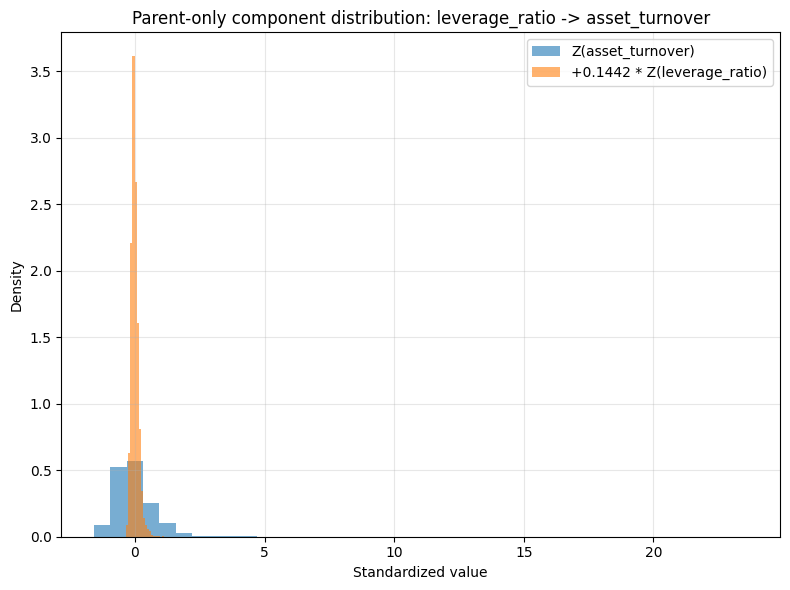

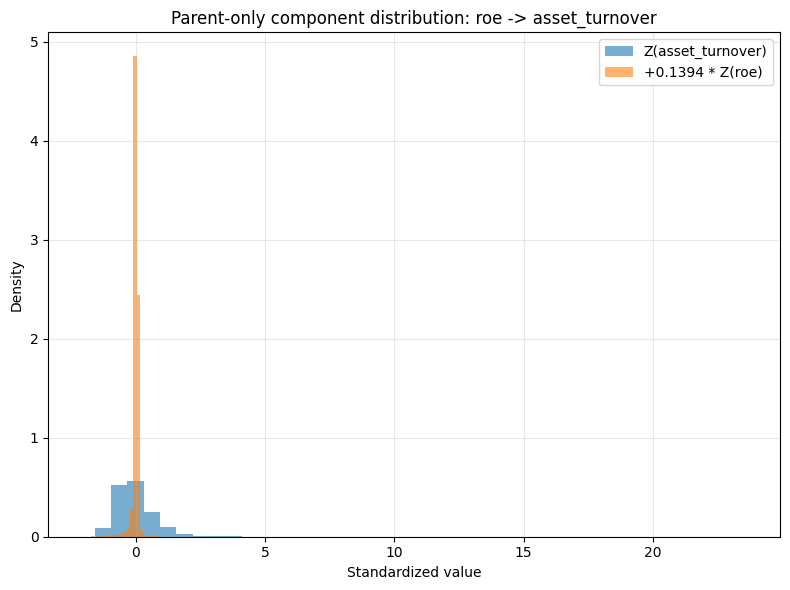

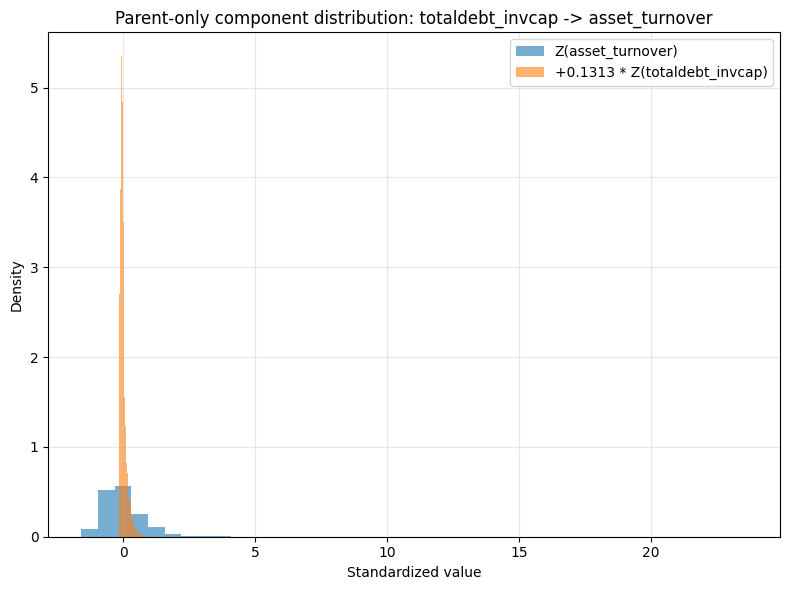

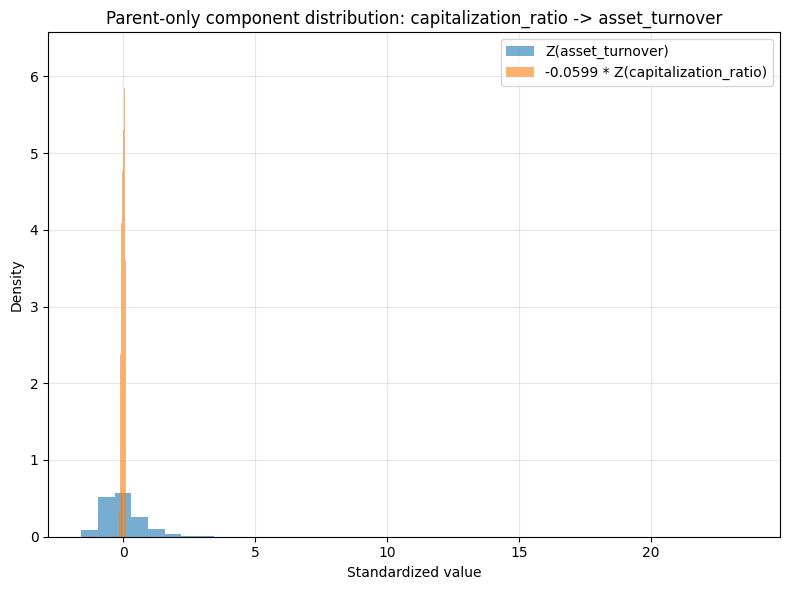

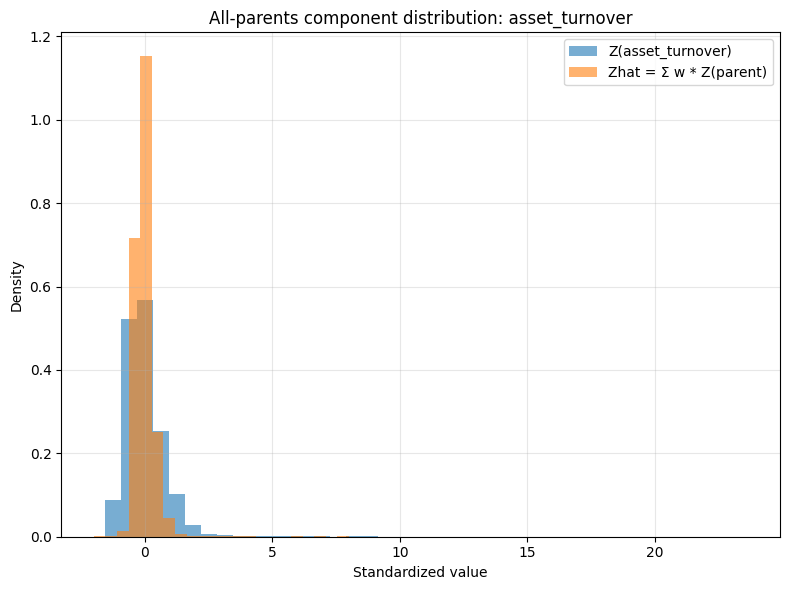


[All-parents component summary (standardized space)]
- num_parents = 5
- corr(Z_target, Zhat_all) = 0.5151
- R^2 (in-sample, standardized) = 0.2653

[Per-parent component correlation with target]
-            rect_turn  w=+0.4397  corr(Z_target, w*Z_p)=0.4382
-       leverage_ratio  w=+0.1442  corr(Z_target, w*Z_p)=0.1583
-                  roe  w=+0.1394  corr(Z_target, w*Z_p)=0.1443
-     totaldebt_invcap  w=+0.1313  corr(Z_target, w*Z_p)=0.2237
- capitalization_ratio  w=-0.0599  corr(Z_target, w*Z_p)=0.0057

[All-parents OLS]
- num_parents = 5
- test R^2    = 0.2247
- corr(y,yhat)= 0.5149


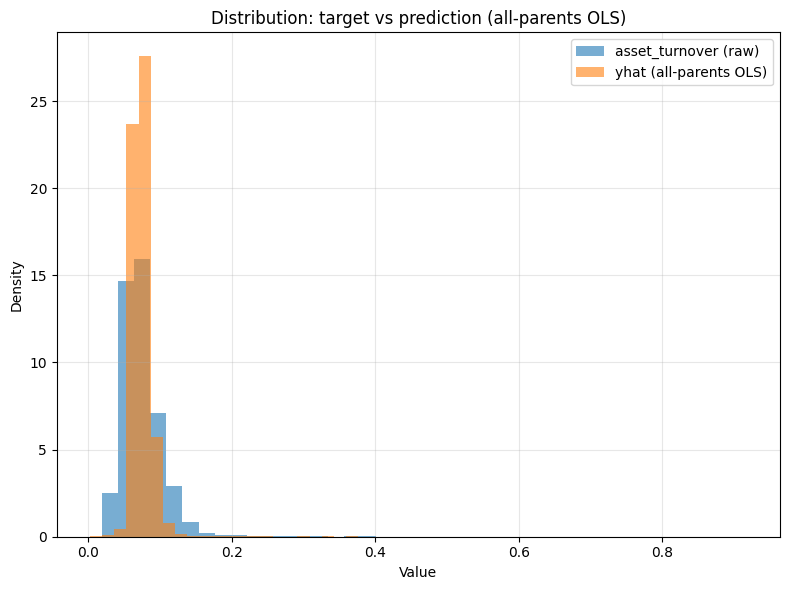

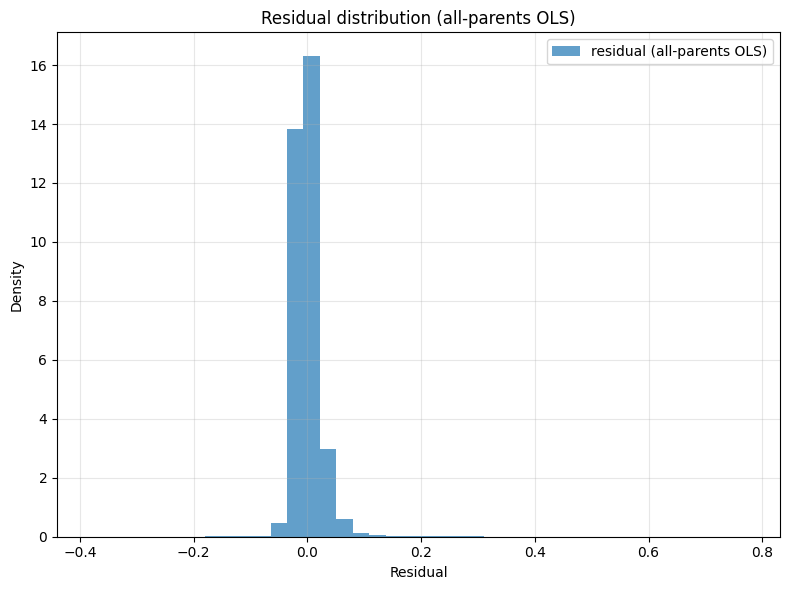

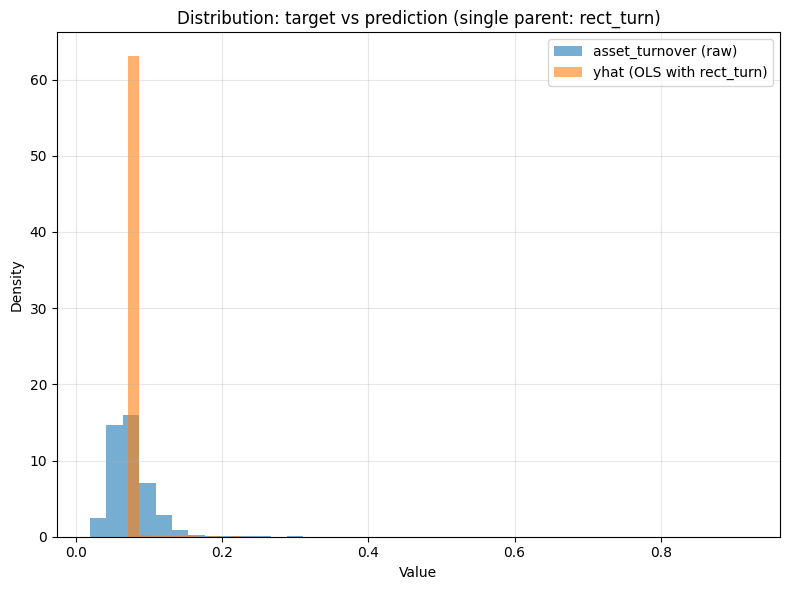

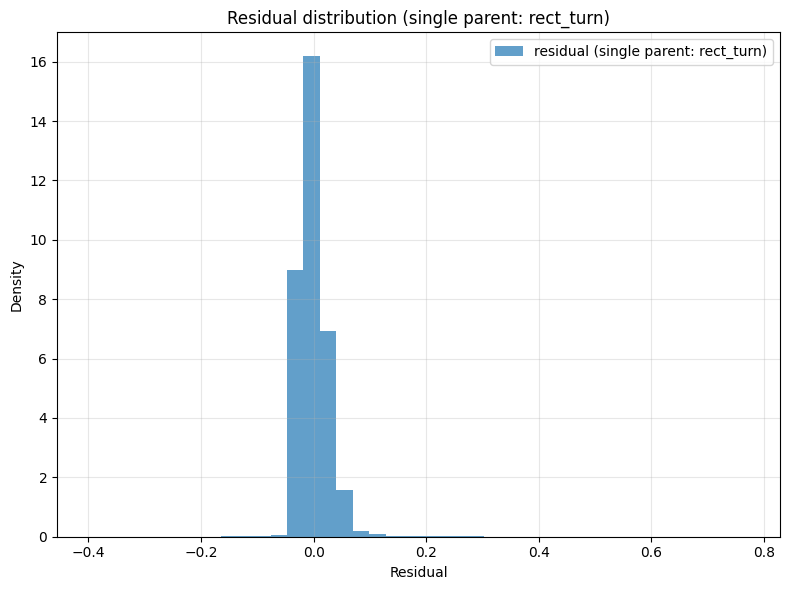

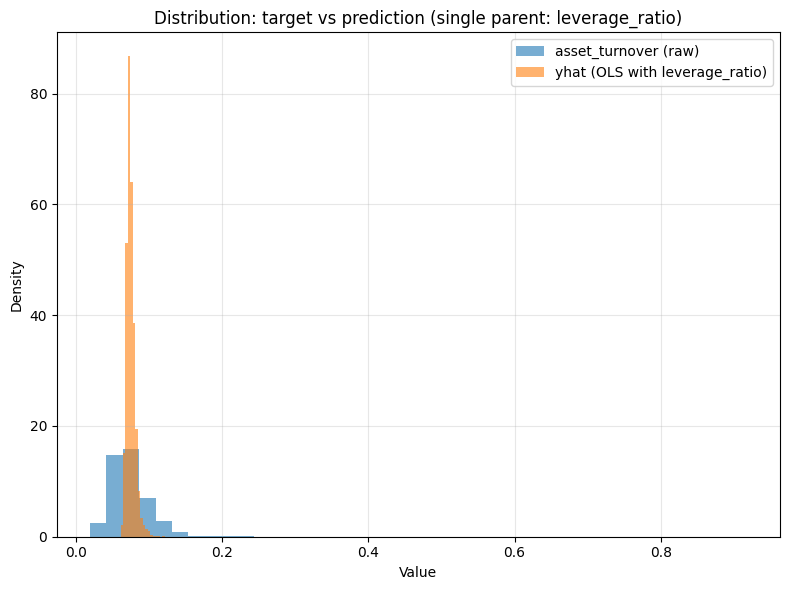

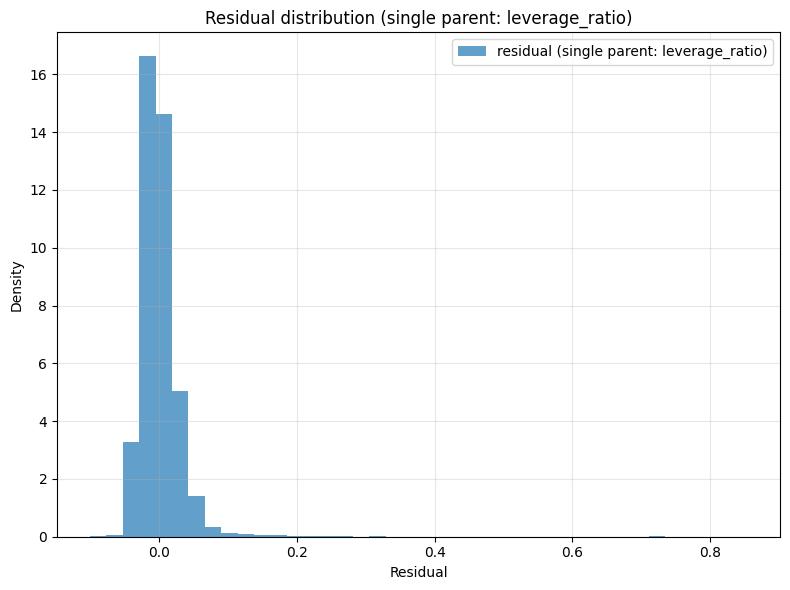

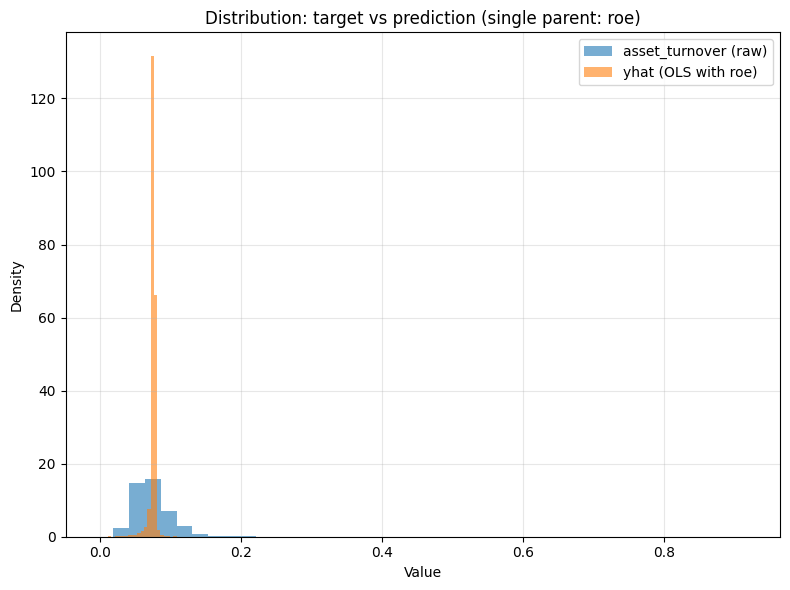

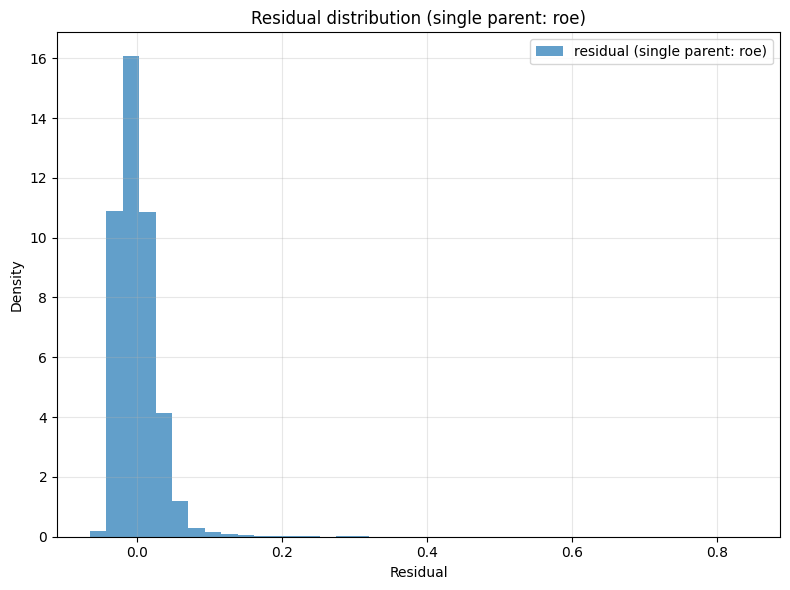

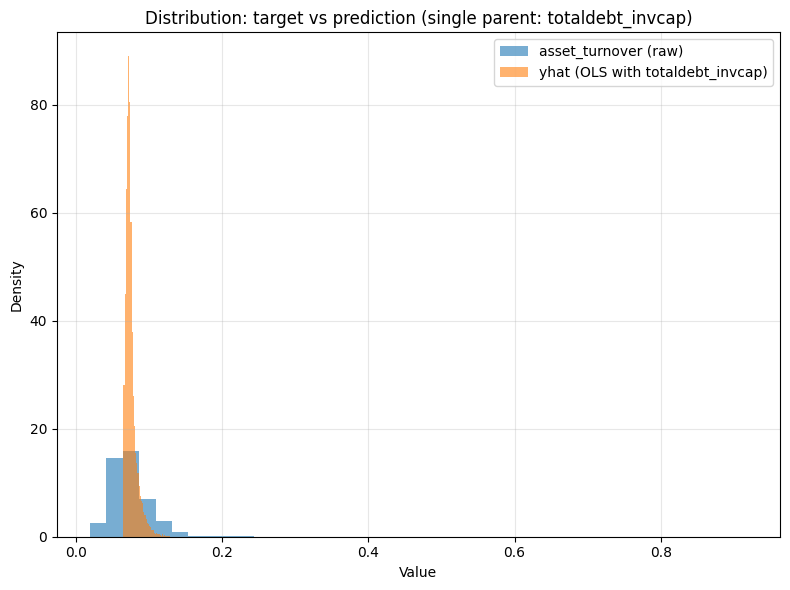

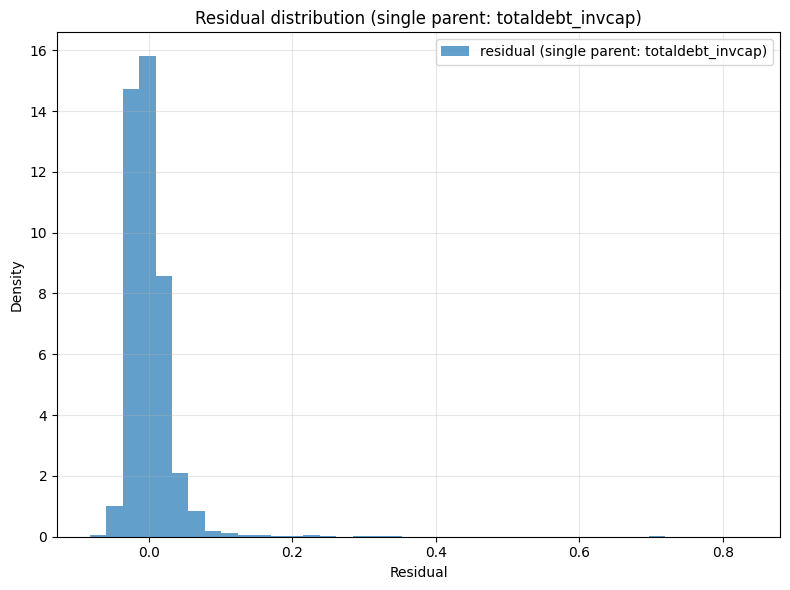

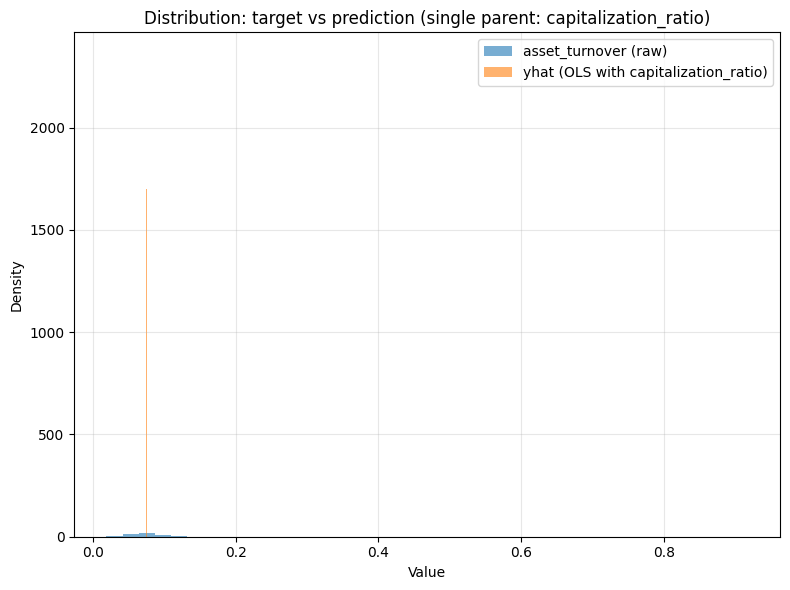

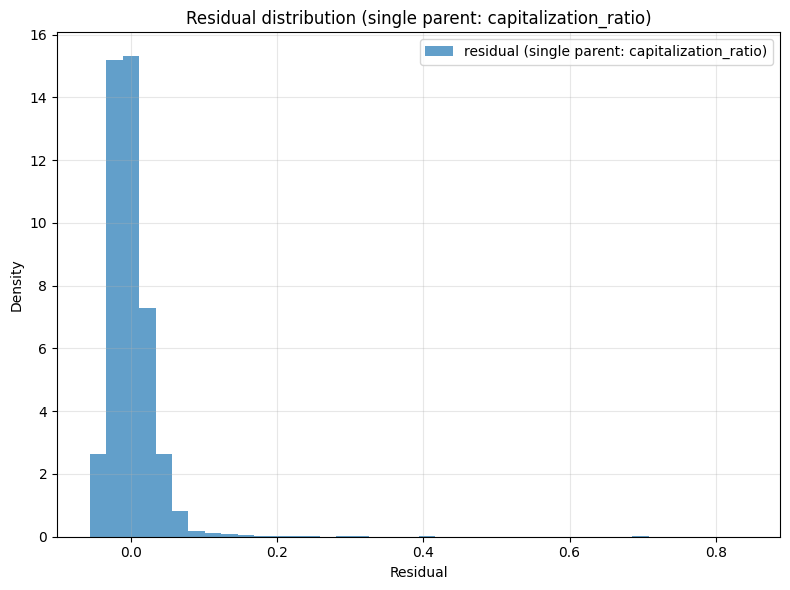


[Single-parent OLS summary (sorted by test R^2)]
              parent   test_R2  corr(y,yhat)  coef_stdX  intercept
           rect_turn  0.172097      0.438207   0.015210   0.075142
    totaldebt_invcap  0.041999      0.223680   0.007843   0.075142
                 roe  0.017392      0.144309   0.005048   0.075142
      leverage_ratio  0.006804      0.158321   0.006047   0.075142
capitalization_ratio -0.000563      0.005698  -0.000160   0.075142

[INFO] Number of numeric variables: 14


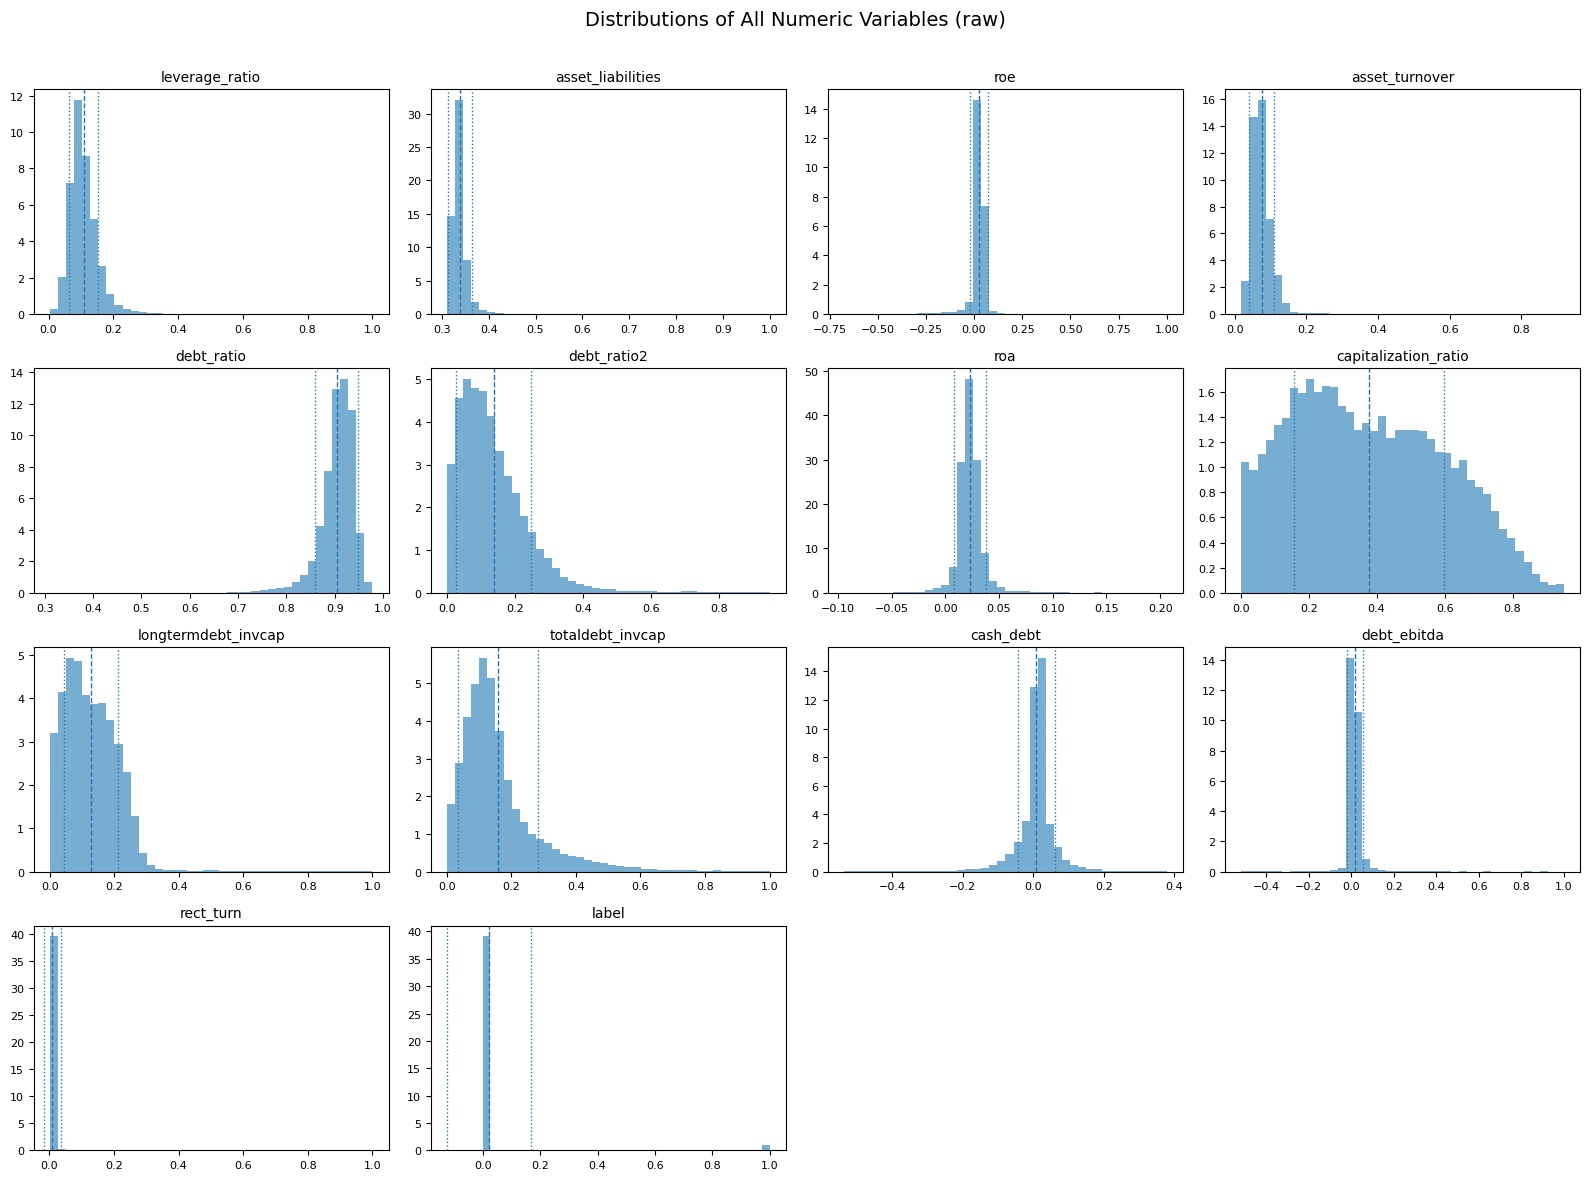

In [3]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import networkx as nx

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from typing import List, Optional, Tuple, Any

# causal-learn: GES
from causallearn.search.ScoreBased.GES import ges


# =========================================================
# 0) 설정
# =========================================================
DATA_PATH = "training_data_original.csv"

TARGET_NAME = "asset_turnover"
LABEL_COL = "label"
DROP_COLS_CANDIDATES = ["Unnamed: 0", "index", "id"]

# ---- 분포 그래프 옵션 ----
DIST_NCOLS = 4
DIST_BINS = 40

# ---- GES / OLS 옵션 ----
# OLS W(엣지 가중치) 추정은 "표준화"를 사용(요구사항 반영)
# 정규화/표준화 둘 다 만들어서 분포 확인 후,
# 실제 OLS는 표준화 데이터로 들어갑니다.
GES_INPUT = "standard"  # {"raw","minmax","standard"} 중 선택(보통 standard 권장)

# ---- 엣지 필터/시각화 옵션 ----
USE_QUANTILE = False
W_THRESHOLD = 0.01
W_ABS_QUANTILE = 0.90
TOP_K_EDGES = None  # 예: 200

FIGSIZE_GRAPH = (10, 8)
LAYOUT_EPS = 1e-6

# ---- 평가/히스토그램 옵션 ----
BINS = 40
TEST_SIZE = 0.2
RANDOM_STATE = 42

OUT_PREFIX = "ges_{0}_ols_standard".format(GES_INPUT)


# =========================================================
# 유틸 함수
# =========================================================
def pick_drop_cols(df: pd.DataFrame, candidates: List[str]) -> List[str]:
    return [c for c in candidates if c in df.columns]

def ensure_numeric_df(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    x = df[cols].copy()
    x = x.apply(pd.to_numeric, errors="coerce")
    return x

def get_threshold(W: np.ndarray,
                  fixed: float = W_THRESHOLD,
                  use_q: bool = USE_QUANTILE,
                  q: float = W_ABS_QUANTILE) -> float:
    if not use_q:
        return float(fixed)
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    if aw.size == 0:
        return float(fixed)
    return float(np.quantile(aw, q))

def ges_to_A_matrix(Gmat: np.ndarray) -> np.ndarray:
    """
    causal-learn GES 그래프 행렬 해석:
    G.graph[j,i]=1 & G.graph[i,j]=-1 이면 i -> j
    A[child, parent] = 1 로 저장
    """
    p = Gmat.shape[0]
    A = np.zeros((p, p), dtype=float)
    for i in range(p):
        for j in range(p):
            if i == j:
                continue
            if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):
                A[j, i] = 1.0
    return A

def estimate_W_by_ols_standardized(Z: np.ndarray, A: np.ndarray) -> np.ndarray:
    """
    표준화(Z-score)된 데이터 Z에서,
    구조 A(=1인 부모들) 기준으로 각 child를 parents로 OLS(절편 없음) 적합
    W[child, parent] = coef
    """
    n, p = Z.shape
    W = np.zeros_like(A, dtype=float)

    for child in range(p):
        parents = np.where(A[child, :] == 1.0)[0]
        if parents.size == 0:
            continue

        y_child = Z[:, child]
        X_par = Z[:, parents]

        coef, _, _, _ = np.linalg.lstsq(X_par, y_child, rcond=None)
        W[child, parents] = coef.astype(float)

    return W

def build_edges_from_W(W: np.ndarray,
                       cols: List[str],
                       thr: float,
                       top_k: Optional[int]) -> List[Tuple[str, str, float]]:
    edges_all = []
    p = len(cols)
    for child in range(p):
        for parent in range(p):
            if child == parent:
                continue
            w = float(W[child, parent])
            if abs(w) > thr:
                edges_all.append((cols[parent], cols[child], w))  # parent -> child

    if top_k is not None and top_k > 0 and len(edges_all) > top_k:
        edges_all = sorted(edges_all, key=lambda t: abs(t[2]), reverse=True)[:top_k]

    return edges_all

def print_edge_summary(edges_all: List[Tuple[str, str, float]],
                       W: np.ndarray,
                       thr: float,
                       top_k: Optional[int]) -> None:
    num_edges = len(edges_all)
    num_pos = sum(1 for _, _, w in edges_all if w >= 0)
    num_neg = num_edges - num_pos
    nonzero_before = int(np.count_nonzero(W))

    print("[EDGE SUMMARY]")
    print("- threshold(|w|) = {0:.6f}".format(thr))
    print("- TOP_K_EDGES = {0}".format(top_k))
    print("- Selected edges = {0} (pos: {1}, neg: {2})".format(num_edges, num_pos, num_neg))
    print("- Nonzero W entries before threshold: {0}".format(nonzero_before))

    for (u, v, w) in sorted(edges_all, key=lambda t: abs(t[2]), reverse=True):
        print("  {0} -> {1}: w={2:+.4f}".format(u, v, w))

def save_edges(edges_all: List[Tuple[str, str, float]], out_csv: str) -> None:
    edges_df = pd.DataFrame(edges_all, columns=["source", "target", "weight"])
    edges_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print("-> edges saved:", out_csv)

def visualize_graph(edges_all: List[Tuple[str, str, float]],
                    title: str,
                    out_png: Optional[str]) -> None:
    G = nx.DiGraph()
    for u, v, w in edges_all:
        G.add_edge(u, v, weight=float(w))

    if G.number_of_edges() == 0:
        print("[WARN] Graph has no edges to visualize.")
        return

    # 레이아웃용: dist = 1/(|w|+eps) (항상 양수)
    H = nx.Graph()
    for u, v, d in G.edges(data=True):
        w = float(d.get("weight", 0.0))
        dist = 1.0 / (abs(w) + LAYOUT_EPS)
        H.add_edge(u, v, weight=dist)

    pos = nx.kamada_kawai_layout(H, weight="weight")

    max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
    pos_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] >= 0]
    neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < 0]

    pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
    neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

    plt.figure(figsize=FIGSIZE_GRAPH)
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=10)

    nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red", width=neg_widths, style="dashed", arrows=True)

    edge_labels = {}
    for u, v in G.edges():
        edge_labels[(u, v)] = "{0:+.3f}".format(float(G[u][v]["weight"]))
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    if out_png is not None:
        plt.savefig(out_png, dpi=200)
        print("-> graph saved:", out_png)
    plt.show()

def extract_edges_to_target(edges_all: List[Tuple[str, str, float]],
                            target: str,
                            out_csv: str) -> List[Tuple[str, str, float]]:
    edges_to_target = [(u, v, w) for (u, v, w) in edges_all if v == target]

    print("\n[{0} 으로 들어가는 edge 목록]".format(target))
    if not edges_to_target:
        print("{0}으로 향하는 edge가 없습니다.".format(target))
        return edges_to_target

    for src, dst, w in sorted(edges_to_target, key=lambda t: abs(t[2]), reverse=True):
        print("{0} - {1:+.4f} - {2}".format(src, w, dst))

    pd.DataFrame(edges_to_target, columns=["source", "target", "weight"])\
      .to_csv(out_csv, index=False, encoding="utf-8-sig")
    print("-> target edges saved:", out_csv)
    return edges_to_target

def plot_distributions_grid(X: np.ndarray, col_names: List[str], title: str,
                            bins: int = DIST_BINS, n_cols: int = DIST_NCOLS) -> None:
    """
    모든 컬럼을 grid로 히스토그램 표시.
    (표준화가 '안 됐다' 판단을 막기 위해, 여기서 평균/표준편차도 같이 표시)
    """
    n = len(col_names)
    n_rows = int(math.ceil(n / float(n_cols)))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), squeeze=False)
    for idx, name in enumerate(col_names):
        r = idx // n_cols
        c = idx % n_cols
        ax = axes[r, c]

        x = X[:, idx]
        x = x[np.isfinite(x)]
        if x.size == 0:
            ax.set_visible(False)
            continue

        mu = float(np.mean(x))
        sd = float(np.std(x, ddof=0))

        ax.hist(x, bins=bins, density=True, alpha=0.7)
        ax.axvline(mu, linestyle="--", linewidth=1)
        ax.set_title("{0}\nmu={1:.3f}, sd={2:.3f}".format(name, mu, sd), fontsize=9)
        ax.tick_params(axis="both", labelsize=8)

    # 남는 칸 숨김
    for j in range(n, n_rows * n_cols):
        r = j // n_cols
        c = j % n_cols
        axes[r, c].set_visible(False)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# =========================================================
# 1) 데이터 로드 + feature 선택 + 수치 변환 + 결측 제거
# =========================================================
df = pd.read_csv(DATA_PATH)

drop_cols = pick_drop_cols(df, DROP_COLS_CANDIDATES)
if LABEL_COL in df.columns:
    drop_cols = drop_cols + [LABEL_COL]

feature_cols = [c for c in df.columns if c not in drop_cols]
X_df = ensure_numeric_df(df, feature_cols)

# GES/OLS 모두 NaN에 취약하므로 일단 dropna 유지
X_df = X_df.dropna()
cols = X_df.columns.tolist()

if len(cols) == 0:
    raise ValueError("사용 가능한 feature가 없습니다. drop/결측 처리 결과 확인 필요")

X_raw = X_df.values.astype(float)
print("[DATA] X_raw shape =", X_raw.shape, "(#features =", len(cols), ")")

# =========================================================
# 2) (요구사항) OLS 전에 정규화/표준화 수행 + 분포 그래프
# =========================================================
# 2-1) 정규화 (MinMax)
mm = MinMaxScaler()
X_minmax = mm.fit_transform(X_raw)

# 2-2) 표준화 (Z-score)
ss = StandardScaler()
X_standard = ss.fit_transform(X_raw)

# 분포를 "실제로" 확인: Raw / MinMax / Standard
plot_distributions_grid(X_raw, cols, title="RAW distributions (before normalization/standardization)")
plot_distributions_grid(X_minmax, cols, title="MinMax normalized distributions")
plot_distributions_grid(X_standard, cols, title="Z-score standardized distributions")

# 여기서 평균/표준편차가 표준화에서 mu≈0, sd≈1로 나오는지 제목에 같이 표시됩니다.
# (히스토그램 모양이 정규분포처럼 보이지 않는 건 정상이며, mu/sd를 보면 표준화 여부가 확실히 확인됩니다.)


# =========================================================
# 3) GES 입력 선택 (raw/minmax/standard 중)
# =========================================================
if GES_INPUT == "raw":
    X_for_ges = X_raw
elif GES_INPUT == "minmax":
    X_for_ges = X_minmax
elif GES_INPUT == "standard":
    X_for_ges = X_standard
else:
    raise ValueError("GES_INPUT must be one of {'raw','minmax','standard'}")

print("[GES INPUT] =", GES_INPUT)


# =========================================================
# 4) GES 실행 -> A(구조)
# =========================================================
Record = ges(X_for_ges)  # 기본 BIC
Gmat = Record["G"].graph
A = ges_to_A_matrix(Gmat)
print("[GES] structure learned. (A[child,parent]=1)")


# =========================================================
# 5) (요구사항) OLS는 '표준화된 데이터'로 W 추정 (기능 유지)
# =========================================================
# 여기서 "표준화가 안 됐다" 문제가 발생하면 안 되도록,
# OLS 입력은 무조건 X_standard를 사용합니다.
W = estimate_W_by_ols_standardized(X_standard, A)
print("[OLS] W estimated on standardized data (Z-score).")


# =========================================================
# 6) 임계 적용 -> edges_all + 시각화 + 저장
# =========================================================
thr = get_threshold(W)
edges_all = build_edges_from_W(W, cols, thr=thr, top_k=TOP_K_EDGES)

print_edge_summary(edges_all, W, thr, TOP_K_EDGES)

edges_csv = "{0}_edges_all.csv".format(OUT_PREFIX)
save_edges(edges_all, edges_csv)

png_path = "{0}_graph.png".format(OUT_PREFIX)
visualize_graph(
    edges_all,
    title="GES({0}) + OLS(standardized) graph (thr={1:.4g})".format(GES_INPUT, thr),
    out_png=png_path
)


# =========================================================
# 7) target(asset_turnover)로 들어오는 edge만 저장
# =========================================================
if TARGET_NAME not in cols:
    print("[WARN] target {0} is not in feature cols (after dropna).".format(TARGET_NAME))
    edges_to_target = []
else:
    target_edges_csv = "{0}_edges_to_{1}.csv".format(OUT_PREFIX, TARGET_NAME)
    edges_to_target = extract_edges_to_target(edges_all, TARGET_NAME, target_edges_csv)


# =========================================================
# 8) (기능 유지) asset_turnover: 부모별 성분 분포 + 부모 종합 성분 분포
#     - Z(target), w*Z(parent), Σ w*Z(parent)
# =========================================================
if TARGET_NAME in cols and len(edges_to_target) > 0:
    # 부모 목록(직접 parent)
    parents_df = pd.DataFrame(edges_to_target, columns=["source", "target", "weight"])
    parents_df["absw"] = parents_df["weight"].abs()
    parents_df = parents_df.sort_values("absw", ascending=False)
    parent_cols = parents_df["source"].tolist()

    # 표준화 데이터에서 column index 매핑
    col_to_idx = {c: i for i, c in enumerate(cols)}
    z_target = X_standard[:, col_to_idx[TARGET_NAME]]

    # 부모별 성분 + 종합
    zhat_all = np.zeros_like(z_target)
    components = []  # (parent, w, comp)
    for _, row in parents_df.iterrows():
        p = row["source"]
        w = float(row["weight"])
        z_p = X_standard[:, col_to_idx[p]]
        comp = w * z_p
        components.append((p, w, comp))
        zhat_all += comp

    # (A) 부모별 성분 분포 vs target
    for p, w, comp in components:
        plt.figure(figsize=(8, 6))
        plt.hist(z_target, bins=BINS, density=True, alpha=0.6, label="Z(asset_turnover)")
        plt.hist(comp, bins=BINS, density=True, alpha=0.6, label="{0:+.4f} * Z({1})".format(w, p))
        plt.xlabel("Standardized value")
        plt.ylabel("Density")
        plt.title("Parent-only component distribution: {0} -> {1}".format(p, TARGET_NAME))
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # (B) 부모 종합 성분 분포 vs target
    plt.figure(figsize=(8, 6))
    plt.hist(z_target, bins=BINS, density=True, alpha=0.6, label="Z(asset_turnover)")
    plt.hist(zhat_all, bins=BINS, density=True, alpha=0.6, label="Zhat = Σ w * Z(parent)")
    plt.xlabel("Standardized value")
    plt.ylabel("Density")
    plt.title("All-parents component distribution: asset_turnover")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    corr_all = float(np.corrcoef(z_target, zhat_all)[0, 1])
    r2_all = float(1.0 - np.sum((z_target - zhat_all) ** 2) / np.sum((z_target - np.mean(z_target)) ** 2))

    print("\n[All-parents component summary (standardized space)]")
    print("- num_parents =", len(parent_cols))
    print("- corr(Z_target, Zhat_all) = {0:.4f}".format(corr_all))
    print("- R^2 (in-sample, standardized) = {0:.4f}".format(r2_all))

    print("\n[Per-parent component correlation with target]")
    for p, w, comp in components:
        corr_p = float(np.corrcoef(z_target, comp)[0, 1])
        print("- {0:>20s}  w={1:+.4f}  corr(Z_target, w*Z_p)={2:.4f}".format(p, w, corr_p))

else:
    print("\n[SKIP] target edges가 없거나 target이 feature에 없어 성분 분포 분석을 건너뜁니다.")


# =========================================================
# 9) (기능 유지) 부모 종합 OLS + 부모 1개씩 OLS (train/test, 분포, 잔차, 저장)
# =========================================================
if TARGET_NAME in df.columns and len(edges_to_target) > 0:
    parents_df2 = pd.DataFrame(edges_to_target, columns=["source", "target", "weight"])
    parents_df2["absw"] = parents_df2["weight"].abs()
    parents_df2 = parents_df2.sort_values("absw", ascending=False)
    parents = parents_df2["source"].tolist()

    # raw 데이터에서 target+parents만 뽑고 결측 제거
    use_cols = [TARGET_NAME] + parents
    data = df[use_cols].apply(pd.to_numeric, errors="coerce").dropna()

    y = data[TARGET_NAME].values
    X_all = data[parents].values

    Xtr, Xte, ytr, yte = train_test_split(
        X_all, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    # -----------------------------
    # (B) 부모 종합 다변량 OLS (X 표준화)
    # -----------------------------
    sc_all = StandardScaler().fit(Xtr)
    lr_all = LinearRegression().fit(sc_all.transform(Xtr), ytr)

    yhat_all = lr_all.predict(sc_all.transform(X_all))
    res_all = y - yhat_all

    yhat_te_all = lr_all.predict(sc_all.transform(Xte))
    r2_te_all = float(r2_score(yte, yhat_te_all))
    corr_all_raw = float(np.corrcoef(y, yhat_all)[0, 1])

    print("\n[All-parents OLS]")
    print("- num_parents =", len(parents))
    print("- test R^2    = {0:.4f}".format(r2_te_all))
    print("- corr(y,yhat)= {0:.4f}".format(corr_all_raw))

    plt.figure(figsize=(8, 6))
    plt.hist(y, bins=BINS, density=True, alpha=0.6, label="{0} (raw)".format(TARGET_NAME))
    plt.hist(yhat_all, bins=BINS, density=True, alpha=0.6, label="yhat (all-parents OLS)")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title("Distribution: target vs prediction (all-parents OLS)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(res_all, bins=BINS, density=True, alpha=0.7, label="residual (all-parents OLS)")
    plt.xlabel("Residual")
    plt.ylabel("Density")
    plt.title("Residual distribution (all-parents OLS)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # (A) 부모 1개씩 단변량 OLS (X 표준화)
    # -----------------------------
    uni_results = []
    for p in parents:
        Xp = data[[p]].values
        Xp_tr, Xp_te, ytr_u, yte_u = train_test_split(
            Xp, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
        )

        sc = StandardScaler().fit(Xp_tr)
        lr = LinearRegression().fit(sc.transform(Xp_tr), ytr_u)

        yhat = lr.predict(sc.transform(Xp))
        res = y - yhat

        yhat_te = lr.predict(sc.transform(Xp_te))
        r2_te = float(r2_score(yte_u, yhat_te))
        corr = float(np.corrcoef(y, yhat)[0, 1])

        uni_results.append({
            "parent": p,
            "test_R2": r2_te,
            "corr(y,yhat)": corr,
            "coef_stdX": float(lr.coef_[0]),
            "intercept": float(lr.intercept_),
        })

        plt.figure(figsize=(8, 6))
        plt.hist(y, bins=BINS, density=True, alpha=0.6, label="{0} (raw)".format(TARGET_NAME))
        plt.hist(yhat, bins=BINS, density=True, alpha=0.6, label="yhat (OLS with {0})".format(p))
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.title("Distribution: target vs prediction (single parent: {0})".format(p))
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.hist(res, bins=BINS, density=True, alpha=0.7, label="residual (single parent: {0})".format(p))
        plt.xlabel("Residual")
        plt.ylabel("Density")
        plt.title("Residual distribution (single parent: {0})".format(p))
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    uni_df = pd.DataFrame(uni_results).sort_values("test_R2", ascending=False)
    print("\n[Single-parent OLS summary (sorted by test R^2)]")
    print(uni_df.to_string(index=False))

    uni_df.to_csv("{0}_single_parent_ols_summary.csv".format(OUT_PREFIX), index=False, encoding="utf-8-sig")

    pd.DataFrame({
        "y": y,
        "yhat_all": yhat_all,
        "res_all": res_all
    }).to_csv("{0}_all_parents_ols_pred_resid.csv".format(OUT_PREFIX), index=False, encoding="utf-8-sig")

else:
    print("\n[SKIP] target edges가 없거나 target 컬럼이 없어 OLS 평가를 건너뜁니다.")


# =========================================================
# 10) (기존 기능에 준함) 전체 수치형 변수 분포(μ, ±1σ) subplot
# =========================================================
num_df = df.select_dtypes(include=[np.number]).copy()
for col in DROP_COLS_CANDIDATES:
    if col in num_df.columns:
        num_df = num_df.drop(columns=[col])

cols_num = num_df.columns.tolist()
n = len(cols_num)
print("\n[INFO] Number of numeric variables:", n)

n_cols = 4
n_rows = int(math.ceil(n / float(n_cols)))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), squeeze=False)

for idx, col in enumerate(cols_num):
    r = idx // n_cols
    c = idx % n_cols
    ax = axes[r, c]

    x = pd.to_numeric(num_df[col], errors="coerce").dropna().values
    if len(x) == 0:
        ax.set_visible(False)
        continue

    mu = float(np.mean(x))
    sigma = float(np.std(x, ddof=1))

    ax.hist(x, bins=BINS, density=True, alpha=0.6)
    ax.axvline(mu, linestyle="--", linewidth=1)
    ax.axvline(mu + sigma, linestyle=":", linewidth=1)
    ax.axvline(mu - sigma, linestyle=":", linewidth=1)

    ax.set_title(col, fontsize=10)
    ax.tick_params(axis="both", labelsize=8)

for j in range(n, n_rows * n_cols):
    r = j // n_cols
    c = j % n_cols
    axes[r, c].set_visible(False)

plt.suptitle("Distributions of All Numeric Variables (raw)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


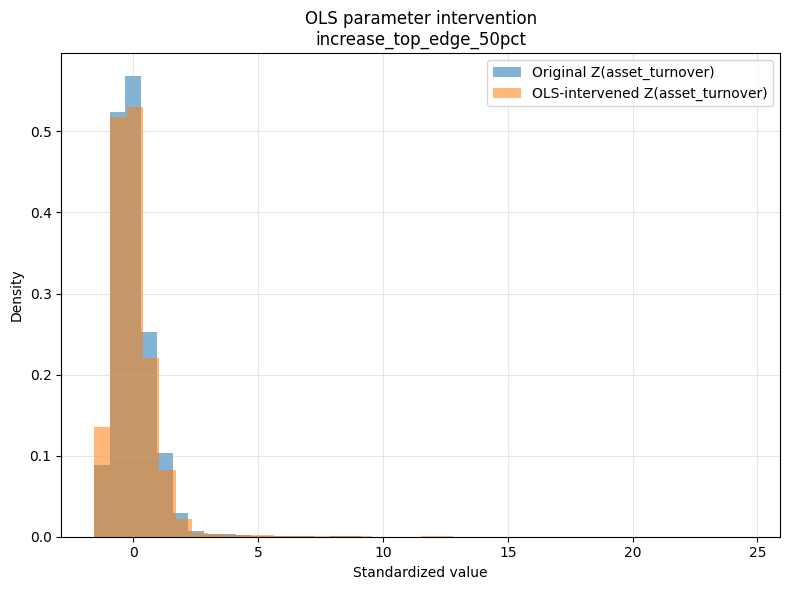


[OLS INTERVENTION SUMMARY]
- name: increase_top_edge_50pct
- mean(Z): original=0.0000, intervened=0.0000
- std(Z):  original=1.0000, intervened=1.1140


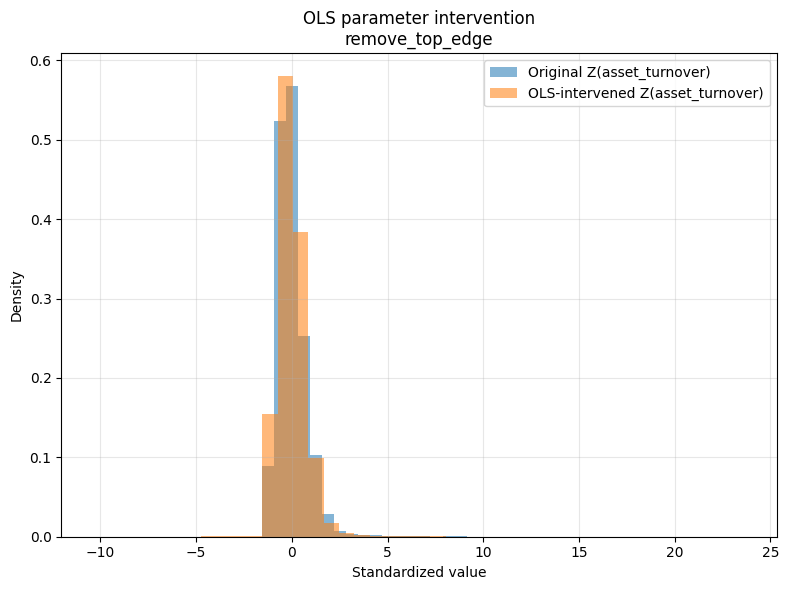


[OLS INTERVENTION SUMMARY]
- name: remove_top_edge
- mean(Z): original=0.0000, intervened=0.0000
- std(Z):  original=1.0000, intervened=0.8989


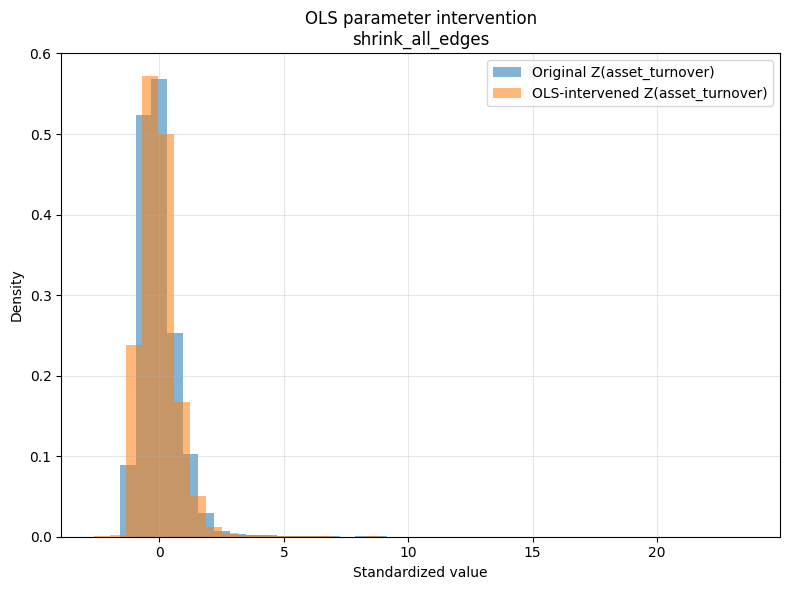


[OLS INTERVENTION SUMMARY]
- name: shrink_all_edges
- mean(Z): original=0.0000, intervened=0.0000
- std(Z):  original=1.0000, intervened=0.9299


In [6]:
# =========================================================
# 8.6) OLS 개입 쉘 (parameter / SEM intervention)
#      - 부모 데이터는 그대로
#      - OLS 계수 w만 개입
# =========================================================

if TARGET_NAME in cols and len(edges_to_target) > 0:

    parents_df_do = pd.DataFrame(edges_to_target,
                                 columns=["source", "target", "weight"])
    parents_df_do["absw"] = parents_df_do["weight"].abs()
    parents_df_do = parents_df_do.sort_values("absw", ascending=False)

    parent_cols = parents_df_do["source"].tolist()
    w_orig = parents_df_do["weight"].astype(float).values

    col_to_idx = {c: i for i, c in enumerate(cols)}
    idx_y = col_to_idx[TARGET_NAME]

    # -----------------------------
    # 원래 Z_y, Z_p, epsilon
    # -----------------------------
    z_y = X_standard[:, idx_y]

    Zp = np.column_stack([
        X_standard[:, col_to_idx[p]] for p in parent_cols
    ])

    zhat_orig = Zp @ w_orig
    eps = z_y - zhat_orig

    # -----------------------------
    # OLS 개입 정의
    # -----------------------------
    OLS_INTERVENTIONS = [
        {
            "name": "increase_top_edge_50pct",
            "mode": "scale_one",
            "parent": parent_cols[0],   # 가장 강한 parent
            "alpha": 1.5
        },
        {
            "name": "remove_top_edge",
            "mode": "zero_one",
            "parent": parent_cols[0]
        },
        {
            "name": "shrink_all_edges",
            "mode": "scale_all",
            "alpha": 0.7
        },
    ]

    # -----------------------------
    # 개입 실행
    # -----------------------------
    for cfg in OLS_INTERVENTIONS:
        w_do = w_orig.copy()

        if cfg["mode"] == "scale_one":
            j = parent_cols.index(cfg["parent"])
            w_do[j] = cfg["alpha"] * w_do[j]

        elif cfg["mode"] == "zero_one":
            j = parent_cols.index(cfg["parent"])
            w_do[j] = 0.0

        elif cfg["mode"] == "scale_all":
            w_do = cfg["alpha"] * w_do

        else:
            raise ValueError("Unknown OLS intervention mode")

        # 새로운 구조식
        z_y_do = Zp @ w_do + eps

        # -----------------------------
        # 분포 비교 (표준화 공간)
        # -----------------------------
        plt.figure(figsize=(8, 6))
        plt.hist(z_y, bins=BINS, density=True, alpha=0.55, label="Original Z(asset_turnover)")
        plt.hist(z_y_do, bins=BINS, density=True, alpha=0.55, label="OLS-intervened Z(asset_turnover)")
        plt.xlabel("Standardized value")
        plt.ylabel("Density")
        plt.title("OLS parameter intervention\n{0}".format(cfg["name"]))
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("\n[OLS INTERVENTION SUMMARY]")
        print("- name:", cfg["name"])
        print("- mean(Z): original={0:.4f}, intervened={1:.4f}"
              .format(float(z_y.mean()), float(z_y_do.mean())))
        print("- std(Z):  original={0:.4f}, intervened={1:.4f}"
              .format(float(z_y.std(ddof=0)), float(z_y_do.std(ddof=0))))


[Residual stats]
mean(eps) = 6.675867099585976e-17
std(eps)  = 0.8571409592485375


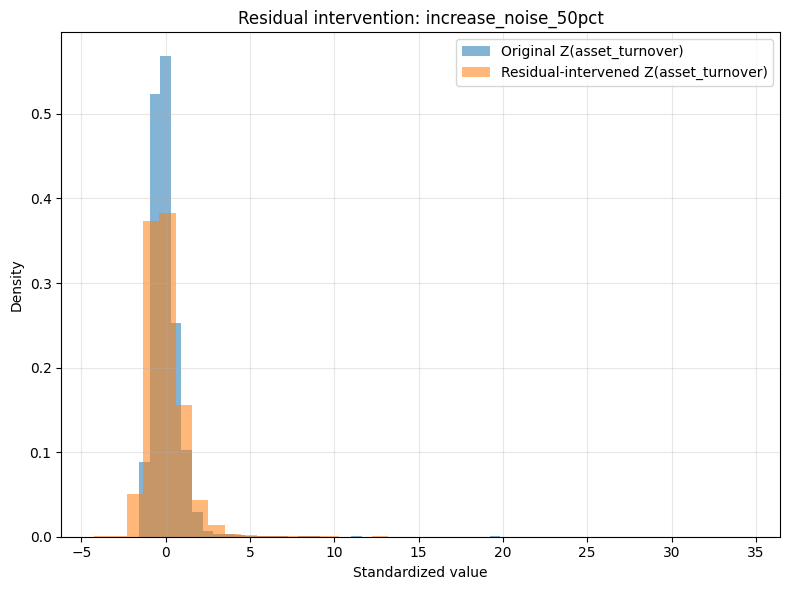


[RESIDUAL INTERVENTION SUMMARY]
- name: increase_noise_50pct
- mean(Z): original=0.0000, intervened=0.0000
- std(Z):  original=1.0000, intervened=1.3850


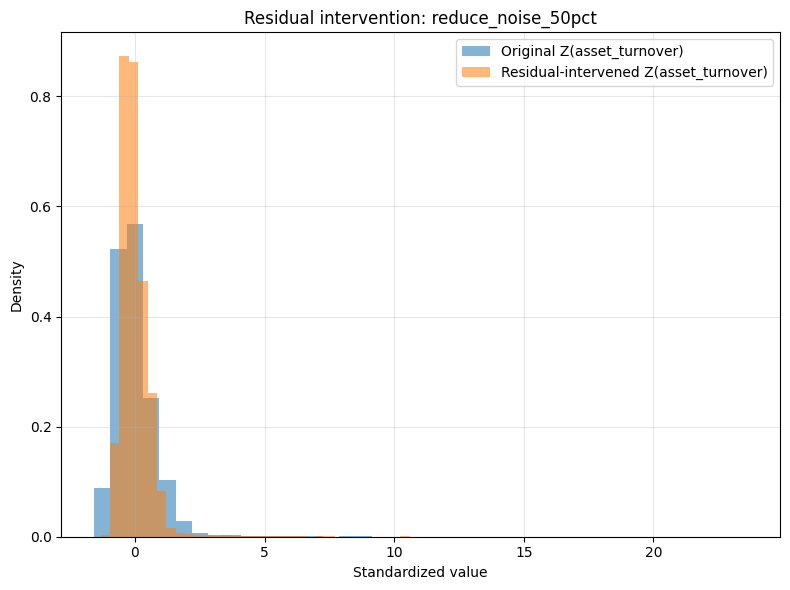


[RESIDUAL INTERVENTION SUMMARY]
- name: reduce_noise_50pct
- mean(Z): original=0.0000, intervened=0.0000
- std(Z):  original=1.0000, intervened=0.6701


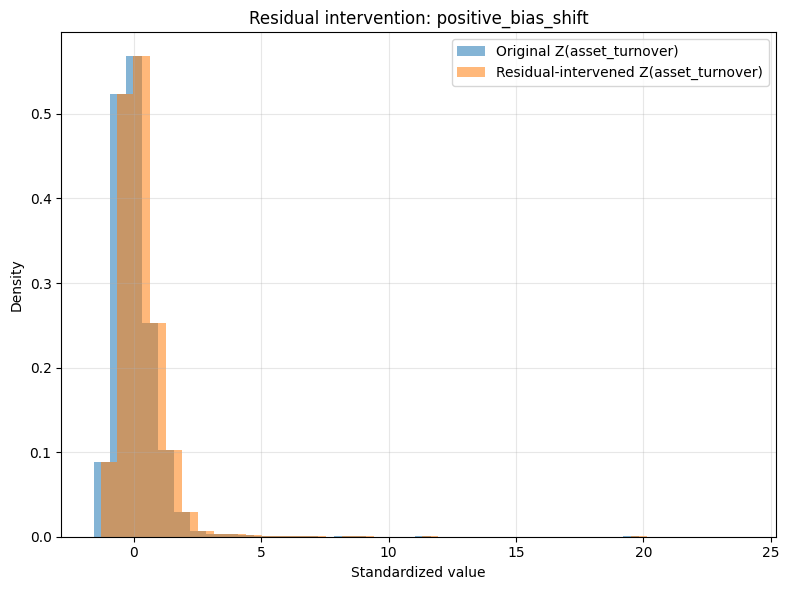


[RESIDUAL INTERVENTION SUMMARY]
- name: positive_bias_shift
- mean(Z): original=0.0000, intervened=0.3000
- std(Z):  original=1.0000, intervened=1.0000


In [7]:
# =========================================================
# Residual (epsilon) intervention shell
# =========================================================

if TARGET_NAME in cols and len(edges_to_target) > 0:

    parents_df_eps = pd.DataFrame(edges_to_target,
                                  columns=["source", "target", "weight"])
    parents_df_eps["absw"] = parents_df_eps["weight"].abs()
    parents_df_eps = parents_df_eps.sort_values("absw", ascending=False)

    parent_cols = parents_df_eps["source"].tolist()
    w = parents_df_eps["weight"].astype(float).values

    col_to_idx = {c: i for i, c in enumerate(cols)}
    idx_y = col_to_idx[TARGET_NAME]

    # ---------------------------------
    # 원래 구성요소
    # ---------------------------------
    z_y = X_standard[:, idx_y]
    Zp = np.column_stack([X_standard[:, col_to_idx[p]] for p in parent_cols])

    zhat = Zp @ w
    eps = z_y - zhat

    print("[Residual stats]")
    print("mean(eps) =", eps.mean())
    print("std(eps)  =", eps.std(ddof=0))

    # ---------------------------------
    # 잔차 개입 시나리오
    # ---------------------------------
    EPS_INTERVENTIONS = [
        {
            "name": "increase_noise_50pct",
            "mode": "scale",
            "alpha": 1.5
        },
        {
            "name": "reduce_noise_50pct",
            "mode": "scale",
            "alpha": 0.5
        },
        {
            "name": "positive_bias_shift",
            "mode": "shift",
            "bias": 0.3
        },
        # {
        #     "name": "resample_noise",
        #     "mode": "resample"
        # },
    ]

    # ---------------------------------
    # 개입 실행
    # ---------------------------------
    for cfg in EPS_INTERVENTIONS:

        if cfg["mode"] == "scale":
            eps_do = cfg["alpha"] * eps

        elif cfg["mode"] == "shift":
            eps_do = eps + cfg["bias"]

        elif cfg["mode"] == "resample":
            mu, sd = eps.mean(), eps.std(ddof=0)
            eps_do = np.random.normal(mu, sd, size=len(eps))

        else:
            raise ValueError("Unknown epsilon intervention mode")

        z_y_do = zhat + eps_do

        # ---------------------------------
        # 분포 비교 (표준화 공간)
        # ---------------------------------
        plt.figure(figsize=(8, 6))
        plt.hist(z_y, bins=BINS, density=True, alpha=0.55, label="Original Z(asset_turnover)")
        plt.hist(z_y_do, bins=BINS, density=True, alpha=0.55,
                 label=f"Residual-intervened Z(asset_turnover)")
        plt.xlabel("Standardized value")
        plt.ylabel("Density")
        plt.title(f"Residual intervention: {cfg['name']}")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("\n[RESIDUAL INTERVENTION SUMMARY]")
        print("- name:", cfg["name"])
        print("- mean(Z): original={:.4f}, intervened={:.4f}"
              .format(z_y.mean(), z_y_do.mean()))
        print("- std(Z):  original={:.4f}, intervened={:.4f}"
              .format(z_y.std(ddof=0), z_y_do.std(ddof=0)))


[INFO] top parent = rect_turn w = 0.4396562440817665


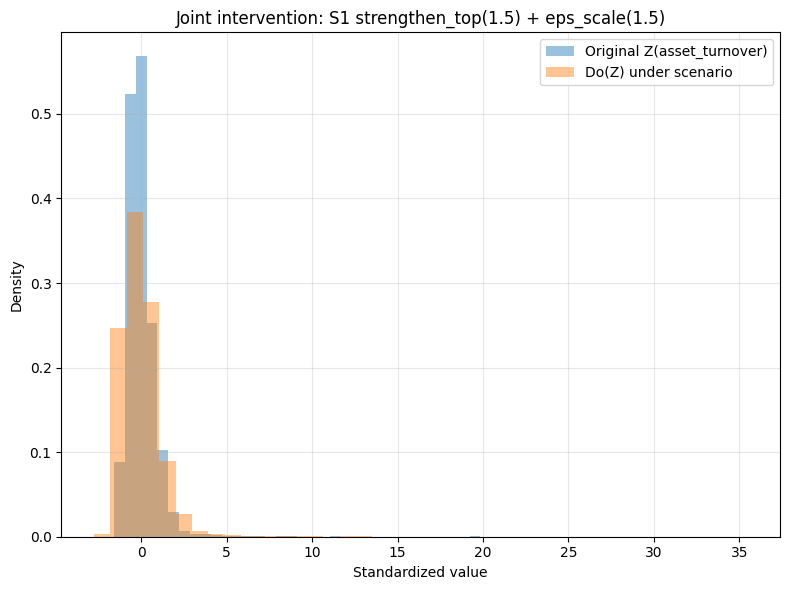


[JOINT INTERVENTION SUMMARY]
- S1 strengthen_top(1.5) + eps_scale(1.5)
  mean(Z): orig=0.0000, do=0.0000
  std(Z):  orig=1.0000, do=1.4695


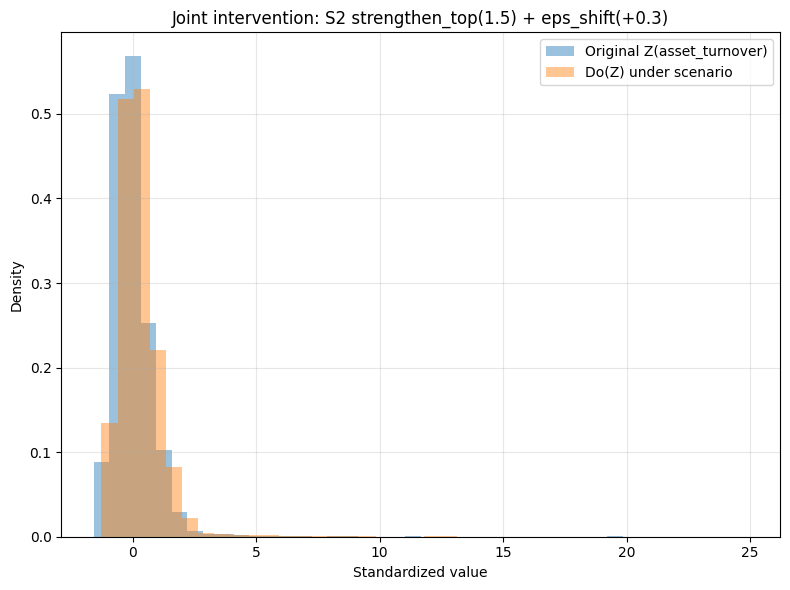


[JOINT INTERVENTION SUMMARY]
- S2 strengthen_top(1.5) + eps_shift(+0.3)
  mean(Z): orig=0.0000, do=0.3000
  std(Z):  orig=1.0000, do=1.1140


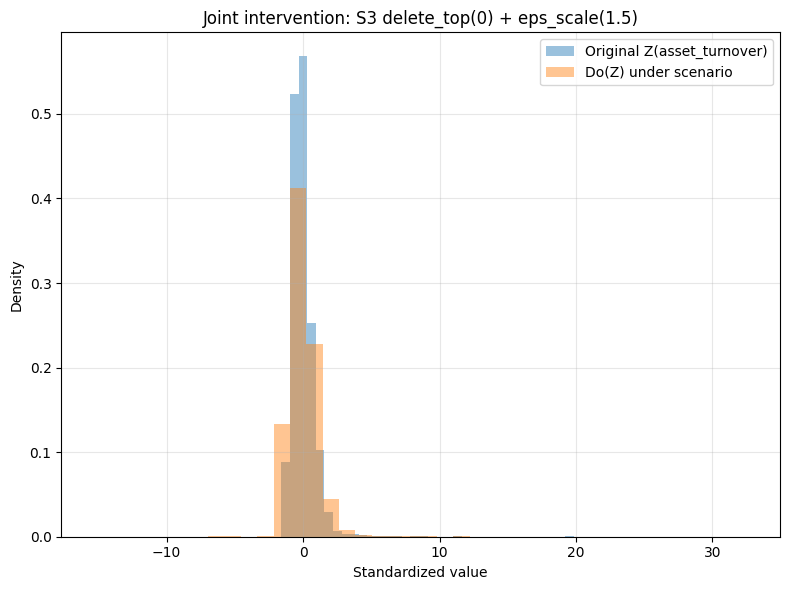


[JOINT INTERVENTION SUMMARY]
- S3 delete_top(0) + eps_scale(1.5)
  mean(Z): orig=0.0000, do=0.0000
  std(Z):  orig=1.0000, do=1.3139


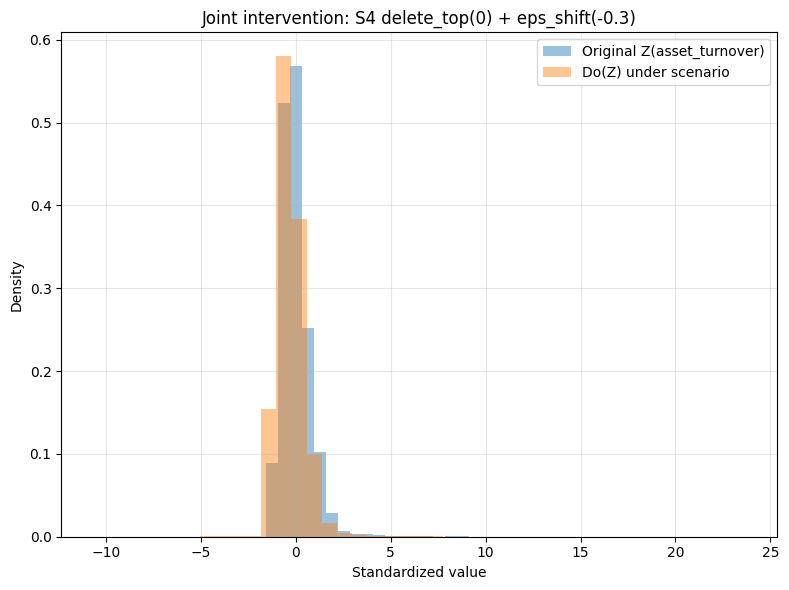


[JOINT INTERVENTION SUMMARY]
- S4 delete_top(0) + eps_shift(-0.3)
  mean(Z): orig=0.0000, do=-0.3000
  std(Z):  orig=1.0000, do=0.8989


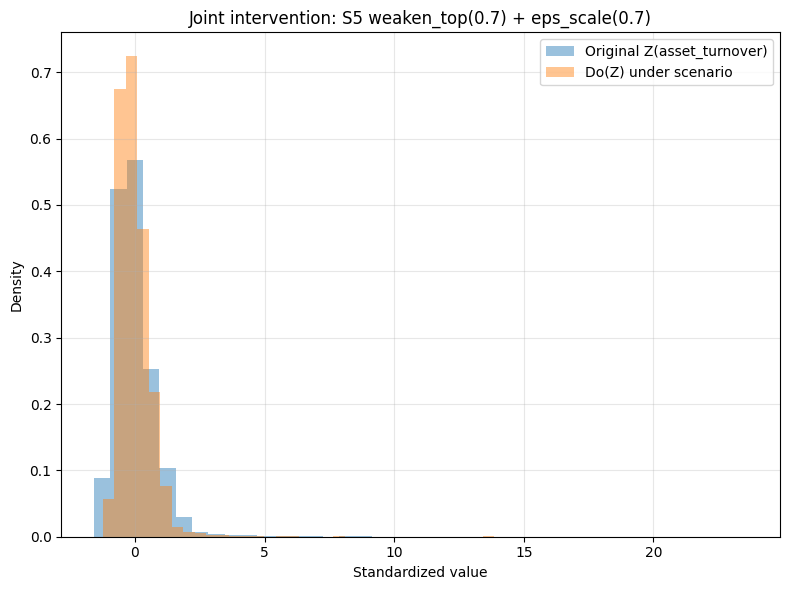


[JOINT INTERVENTION SUMMARY]
- S5 weaken_top(0.7) + eps_scale(0.7)
  mean(Z): orig=0.0000, do=0.0000
  std(Z):  orig=1.0000, do=0.7260


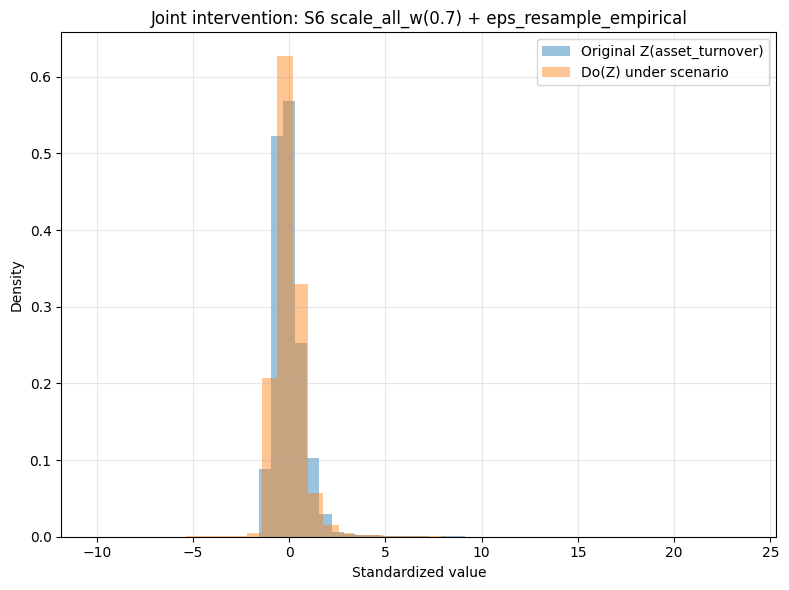


[JOINT INTERVENTION SUMMARY]
- S6 scale_all_w(0.7) + eps_resample_empirical
  mean(Z): orig=0.0000, do=0.0120
  std(Z):  orig=1.0000, do=0.9572


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def intervene_weights(w_orig, parent_cols, mode, alpha=1.0, target_parent=None, top_idx=0):
    w_do = w_orig.copy()

    if mode == "scale_one":
        if target_parent is None:
            target_parent = parent_cols[top_idx]
        j = parent_cols.index(target_parent)
        w_do[j] = alpha * w_do[j]

    elif mode == "zero_one":
        if target_parent is None:
            target_parent = parent_cols[top_idx]
        j = parent_cols.index(target_parent)
        w_do[j] = 0.0

    elif mode == "scale_all":
        w_do = alpha * w_do

    else:
        raise ValueError("Unknown weight intervention mode")

    return w_do

def intervene_eps(eps, mode, beta=1.0, bias=0.0, seed=42):
    if mode == "scale":
        return beta * eps
    if mode == "shift":
        return eps + bias
    if mode == "resample_normal":
        rng = np.random.default_rng(seed)
        mu, sd = eps.mean(), eps.std(ddof=0)
        return rng.normal(mu, sd, size=len(eps))
    if mode == "resample_empirical":
        rng = np.random.default_rng(seed)
        idx = rng.integers(0, len(eps), size=len(eps))
        return eps[idx]
    raise ValueError("Unknown eps intervention mode")

if TARGET_NAME in cols and len(edges_to_target) > 0:
    parents_df = pd.DataFrame(edges_to_target, columns=["source", "target", "weight"])
    parents_df["absw"] = parents_df["weight"].abs()
    parents_df = parents_df.sort_values("absw", ascending=False)

    parent_cols = parents_df["source"].tolist()
    w_orig = parents_df["weight"].astype(float).values

    col_to_idx = {c: i for i, c in enumerate(cols)}
    idx_y = col_to_idx[TARGET_NAME]

    # 원래 구성요소
    z_y = X_standard[:, idx_y]
    Zp = np.column_stack([X_standard[:, col_to_idx[p]] for p in parent_cols])
    zhat = Zp @ w_orig
    eps = z_y - zhat

    top_parent = parent_cols[0]
    print("[INFO] top parent =", top_parent, "w =", w_orig[0])

    # ===== 동시 개입 시나리오 정의 =====
    SCENARIOS = [
        # S1
        dict(
            name="S1 strengthen_top(1.5) + eps_scale(1.5)",
            w_mode="scale_one", w_alpha=1.5, w_parent=top_parent,
            e_mode="scale", e_beta=1.5, e_bias=0.0
        ),
        # S2
        dict(
            name="S2 strengthen_top(1.5) + eps_shift(+0.3)",
            w_mode="scale_one", w_alpha=1.5, w_parent=top_parent,
            e_mode="shift", e_beta=1.0, e_bias=0.3
        ),
        # S3
        dict(
            name="S3 delete_top(0) + eps_scale(1.5)",
            w_mode="zero_one", w_alpha=0.0, w_parent=top_parent,
            e_mode="scale", e_beta=1.5, e_bias=0.0
        ),
        # S4
        dict(
            name="S4 delete_top(0) + eps_shift(-0.3)",
            w_mode="zero_one", w_alpha=0.0, w_parent=top_parent,
            e_mode="shift", e_beta=1.0, e_bias=-0.3
        ),
        # S5
        dict(
            name="S5 weaken_top(0.7) + eps_scale(0.7)",
            w_mode="scale_one", w_alpha=0.7, w_parent=top_parent,
            e_mode="scale", e_beta=0.7, e_bias=0.0
        ),
        # S6
        dict(
            name="S6 scale_all_w(0.7) + eps_resample_empirical",
            w_mode="scale_all", w_alpha=0.7, w_parent=None,
            e_mode="resample_empirical", e_beta=1.0, e_bias=0.0
        ),
    ]

    # ===== 실행 + 분포 비교 =====
    for s in SCENARIOS:
        w_do = intervene_weights(
            w_orig=w_orig,
            parent_cols=parent_cols,
            mode=s["w_mode"],
            alpha=s["w_alpha"],
            target_parent=s["w_parent"],
            top_idx=0
        )
        eps_do = intervene_eps(
            eps=eps,
            mode=s["e_mode"],
            beta=s["e_beta"],
            bias=s["e_bias"],
            seed=RANDOM_STATE
        )

        z_y_do = (Zp @ w_do) + eps_do

        plt.figure(figsize=(8, 6))
        plt.hist(z_y, bins=BINS, density=True, alpha=0.45, label="Original Z(asset_turnover)")
        plt.hist(z_y_do, bins=BINS, density=True, alpha=0.45, label="Do(Z) under scenario")
        plt.xlabel("Standardized value")
        plt.ylabel("Density")
        plt.title("Joint intervention: " + s["name"])
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("\n[JOINT INTERVENTION SUMMARY]")
        print("-", s["name"])
        print("  mean(Z): orig={:.4f}, do={:.4f}".format(z_y.mean(), z_y_do.mean()))
        print("  std(Z):  orig={:.4f}, do={:.4f}".format(z_y.std(ddof=0), z_y_do.std(ddof=0)))
else:
    print("[SKIP] target edges가 없거나 target이 feature에 없습니다.")
